# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

**Тариф «Смарт»**

Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета: 

1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
2. сообщение: 3 рубля; 
3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**

Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета: 
1. минута разговора: 1 рубль; 
2. сообщение: 1 рубль; 
3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. 

### Описание данных
**Таблица users (информация о пользователях):**
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tarif — название тарифного плана

**Таблица calls (информация о звонках):**
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение данных из файлов

### Загрузка необходимых библиотек

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
from scipy import stats as st
%matplotlib inline

### Загрузка данных в датафреймы

In [3]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

### Проверка данных

In [4]:
table_names = {'users': users, 'calls': calls, 'messages': messages, 'internet': internet, 'tariffs': tariffs}

for table_name, df_name in table_names.items():
    print('_' * 100, 'Таблица', table_name)
    display(df_name.head(2)) # Вывод нескольких строк таблицы
    print(df_name.info()) # Служебная инфо о таблице
    print('Дубликаты:', df_name.duplicated().sum()) # Проверка дубликатов

____________________________________________________________________________________________________ Таблица users


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
Дубликаты: 0
____________________________________________________________________________________________________ Таблица calls


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
Дубликаты: 0
____________________________________________________________________________________________________ Таблица messages


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
Дубликаты: 0
____________________________________________________________________________________________________ Таблица internet


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
Дубликаты: 0
____________________________________________________________________________________________________ Таблица tariffs


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None
Дубликаты: 0


### Выводы

**Таблица users:** Есть пропуски в столбце churn_date там, где контракт не завершен (получим последнюю дату в непропущенных данных и присвоим пропускам на 1-2 дня позже, как пограничное значение), далее переведем формат в datetime. Столбец reg_date переведем в datetime. Дубликатов нет.

**Таблица: calls:** Столбец call_date переведем в datetime. Пропусков и дубликатов нет.

**Таблица: messages**: Столбец message_date переведем в datetime. Пропусков и дубликатов нет.

**Таблица: internet**: Столбец session_date переведем в datetime. Пропусков и дубликатов нет. Присутствует лишний столбец Unnamed: 0, совпадающий с индексом - уберем его.

**Таблица: tariffs**: Никаких претензий.

## Предобработка данных

### Таблица users

#### Столбцы churn_date  — дата прекращения пользования тарифом и reg_date — дата подключения тарифа

Получим последнюю дату в непропущенных данных и присвоим пропускам значение на 1-2 дня позже

In [5]:
users['churn_date'].value_counts().head()

2018-12-21    2
2018-10-14    2
2018-10-03    2
2018-12-09    2
2018-12-03    2
Name: churn_date, dtype: int64

In [6]:
users[users['churn_date'].notna()]['churn_date'].max()

'2018-12-30'

Для простоты присвоим пропускам значение '2019-01-01' и убедимся, что пропусков нет

In [7]:
users.loc[users['churn_date'].isna(), 'churn_date'] = '2019-01-01' 
users[users['churn_date'].isna()]['churn_date'].count() 

0

In [8]:
users['churn_date'].value_counts().head()

2019-01-01    462
2018-10-14      2
2018-10-03      2
2018-12-09      2
2018-12-21      2
Name: churn_date, dtype: int64

Переведем формат в datetime согласно плану

In [9]:
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
users.dtypes

user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object

In [10]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2019-01-01,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2019-01-01,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2019-01-01,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2019-01-01,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,2019-01-01,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,2019-01-01,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,2019-01-01,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [11]:
# Неявных дуликатов нет

users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

### Таблица calls

#### Столбец call_date

Переведем формат в datetime согласно плану

In [12]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
calls['call_date'].head()

0   2018-07-25
1   2018-08-17
2   2018-06-11
3   2018-09-21
4   2018-12-15
Name: call_date, dtype: datetime64[ns]

In [13]:
calls.head(2)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000


### Таблица messages

#### Столбец message_date

Переведем формат в datetime

In [14]:
messages['message_date'] = pd.to_datetime(messages['message_date'])
messages['message_date'].head()

0   2018-06-27
1   2018-10-08
2   2018-08-04
3   2018-06-16
4   2018-12-05
Name: message_date, dtype: datetime64[ns]

In [15]:
messages.head(2)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000


### Таблица internet

####  Столбец session_date

Переведем формат в datetime

In [16]:
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet['session_date'].head()

0   2018-11-25
1   2018-09-07
2   2018-06-25
3   2018-08-22
4   2018-09-24
Name: session_date, dtype: datetime64[ns]

In [17]:
internet.head(2)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000


In [18]:
internet = internet.drop(['Unnamed: 0'], axis=1)

Уберем лишний столбец "Unnamed: 0"

In [19]:
internet.head(2)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000


### Выводы

Данные приведены к нужным типам.
Исправлена ошибка в данных в виде лишнего столбца в таблице internet. Для правильной обработки данных пропускам в столбце churn_date таблицы users присвоили значение, выходящее за временные рамки исследования.
Звонки с нулевой продолжительностью оставили, так как то не ошибка: нулями обозначены пропущенные звонки, поэтому их удалять не нужно.

## Предварительные рассчеты

Посчитаем для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

### Количество сделанных звонков и израсходованных минут разговора по месяцам

#### Столбцы duration_min и call_month

Введем новый столбец duration_min в таблице calls для подсчета длительности звонков, учитываемых согласно тарифному правилу: округлим до целых в большую сторону и переведем в int

In [20]:
calls['duration_min'] = np.ceil(calls['duration']).astype(int)
display(calls['duration'].head())
calls['duration_min'].head()

0     0.00
1     0.00
2     2.85
3    13.80
4     5.18
Name: duration, dtype: float64

0     0
1     0
2     3
3    14
4     6
Name: duration_min, dtype: int64

Введем также столбец call_month для данных о месяце звонка

In [21]:
calls['call_month'] = calls['call_date'].dt.month

In [22]:
calls.head()

,id,call_date,duration,user_id,duration_min,call_month
0,1000_0,2018-07-25,0.00,1000,0,7
1,1000_1,2018-08-17,0.00,1000,0,8
2,1000_2,2018-06-11,2.85,1000,3,6
3,1000_3,2018-09-21,13.80,1000,14,9
4,1000_4,2018-12-15,5.18,1000,6,12


#### Сводная таблица количества сделанных звонков по месяцам

In [23]:
calls_count_pivot = calls.pivot_table(index=['user_id'],
                                      columns=['call_month'],
                                      values=['duration_min'],
                                      aggfunc=['count']).fillna(0).reset_index() # Заполним пропуски 0 и сбросим индексацию

In [24]:
# Избавимся от множественнго индексирования

col = ['user_id']
col.extend([str(x) for x in range(1, 13)])
col

['user_id', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

In [25]:
calls_count_pivot.set_axis(col, axis = 'columns', inplace=True)
calls_count_pivot

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0.0,0.0,0.0,0.0,22.0,43.0,47.0,52.0,58.0,57.0,43.0,46.0
1,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,63.0
2,1002,0.0,0.0,0.0,0.0,0.0,15.0,26.0,42.0,36.0,33.0,32.0,33.0
3,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,134.0,108.0,115.0,108.0
4,1004,0.0,0.0,0.0,0.0,9.0,31.0,22.0,19.0,26.0,29.0,19.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,112.0,152.0,129.0,155.0
488,1496,7.0,77.0,79.0,67.0,63.0,74.0,73.0,88.0,68.0,72.0,80.0,80.0
489,1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,64.0,71.0
490,1498,0.0,0.0,0.0,0.0,0.0,0.0,23.0,57.0,59.0,41.0,0.0,0.0


#### Сводная таблица израсходованных минут разговора по месяцам

In [26]:
calls_sum_pivot = calls.pivot_table(index=['user_id'],
                                    columns=['call_month'],
                                    values=['duration_min'],
                                    aggfunc=['sum']).fillna(0).reset_index()

calls_sum_pivot.set_axis(col, axis = 'columns', inplace=True)
calls_sum_pivot

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0.0,0.0,0.0,0.0,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,430.0,414.0
2,1002,0.0,0.0,0.0,0.0,0.0,117.0,214.0,289.0,206.0,212.0,243.0,236.0
3,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,380.0,961.0,855.0,824.0,802.0
4,1004,0.0,0.0,0.0,0.0,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,813.0,1030.0,954.0,1031.0
488,1496,48.0,594.0,557.0,521.0,484.0,555.0,582.0,527.0,486.0,450.0,662.0,518.0
489,1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,490.0,371.0,545.0
490,1498,0.0,0.0,0.0,0.0,0.0,0.0,175.0,400.0,471.0,247.0,0.0,0.0


In [27]:
calls_sum_pivot2 = calls.pivot_table(index=['user_id', 'call_month'],
                                    values=['duration_min'],
                                    aggfunc=['sum']).fillna(0).reset_index()

calls_sum_pivot2.set_axis(['user_id', 'call_month', 'duration'], axis = 'columns', inplace=True)
calls_sum_pivot2

,user_id,call_month,duration
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466
...,...,...,...
3169,1498,10,247
3170,1499,9,70
3171,1499,10,449
3172,1499,11,612


#### Обработка сводных таблиц по данным звонков по месяцам

Видим, что в обеих сводных таблицах и в таблице calls пропущены 8 из 500 пользователей. 

In [28]:
len(calls['user_id'].unique())

492

Выясним их user_id и посмотрим по другим таблицам с чем это связано.

In [29]:
user_id_notin_calls = [x for x in range(1000, 1500) if x not in calls['user_id'].unique()]
user_id_notin_calls

[1091, 1106, 1128, 1231, 1328, 1371, 1473, 1489]

Убеждаемся, что в таблице calls нет именно этих user_id.

In [30]:
calls.query('user_id in @user_id_notin_calls')

,id,call_date,duration,user_id,duration_min,call_month


А в других таблицах данные присутствуют

In [31]:
users.query('user_id in @user_id_notin_calls')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
91,1091,36,2019-01-01,Набережные Челны,Вера,Суслова,2018-05-08,ultra
106,1106,67,2019-01-01,Калуга,Исаак,Костин,2018-04-26,ultra
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
231,1231,63,2019-01-01,Чебоксары,Касьян,Авдюков,2018-05-23,ultra
328,1328,44,2019-01-01,Мурманск,Рауль,Аркадьев,2018-10-16,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart
473,1473,18,2019-01-01,Красноярск,Николай,Лебедев,2018-08-05,ultra
489,1489,35,2019-01-01,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart


In [32]:
messages.query('user_id in @user_id_notin_calls')

,id,message_date,user_id
21447,1091_0,2018-09-23,1091
21448,1091_1,2018-09-04,1091
21449,1091_2,2018-08-11,1091
21450,1091_3,2018-09-02,1091
21451,1091_4,2018-10-16,1091
...,...,...,...
120773,1489_120,2018-11-03,1489
120774,1489_121,2018-09-19,1489
120775,1489_122,2018-08-26,1489
120776,1489_123,2018-08-30,1489


In [33]:
internet.query('user_id in @user_id_notin_calls')

,id,mb_used,session_date,user_id
26130,1091_0,608.94,2018-09-06,1091
26131,1091_1,645.77,2018-06-16,1091
26132,1091_2,449.75,2018-12-31,1091
26133,1091_3,158.03,2018-08-21,1091
26134,1091_4,1237.07,2018-08-08,1091
...,...,...,...,...
146252,1489_261,413.13,2018-10-29,1489
146253,1489_262,200.95,2018-11-21,1489
146254,1489_263,513.46,2018-12-11,1489
146255,1489_264,486.17,2018-08-26,1489


Можно сделать вывод, что эти 8 не пользуются мобильной связью, а только сетью интернет и sms. Поэтому следует дополнить сводные таблицы недостающими user_id и проставить 0 в длительности и количестве звонков по всем месяцам

Создадим датафрейм с недостающими данными

In [34]:
a1 = {'user_id': user_id_notin_calls} # Создадим словарь с пропущенными user_id

# Сгенерируем словарь 8 х 12 с месяцами в ключах, заполненный 0 
b1 = {str(x): [0 for y in range(0, 8)] for x in range(1, 13)}

all_calls_0 = pd.DataFrame({**a1, **b1}) # Объединим 2 словаря и создадим датафрейм на их основе 

all_calls_0 

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1091,0,0,0,0,0,0,0,0,0,0,0,0
1,1106,0,0,0,0,0,0,0,0,0,0,0,0
2,1128,0,0,0,0,0,0,0,0,0,0,0,0
3,1231,0,0,0,0,0,0,0,0,0,0,0,0
4,1328,0,0,0,0,0,0,0,0,0,0,0,0
5,1371,0,0,0,0,0,0,0,0,0,0,0,0
6,1473,0,0,0,0,0,0,0,0,0,0,0,0
7,1489,0,0,0,0,0,0,0,0,0,0,0,0


Добавим его в сводные таблицы и переведем формат в целые числа

In [35]:
calls_count_pivot = pd.concat([calls_count_pivot, all_calls_0], sort=False) \
                                .sort_values(by='user_id').reset_index(drop=True).astype('int')


calls_count_pivot

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0,0,0,0,22,43,47,52,58,57,43,46
1,1001,0,0,0,0,0,0,0,0,0,0,59,63
2,1002,0,0,0,0,0,15,26,42,36,33,32,33
3,1003,0,0,0,0,0,0,0,55,134,108,115,108
4,1004,0,0,0,0,9,31,22,19,26,29,19,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,17,112,152,129,155
496,1496,7,77,79,67,63,74,73,88,68,72,80,80
497,1497,0,0,0,0,0,0,0,0,0,66,64,71
498,1498,0,0,0,0,0,0,23,57,59,41,0,0


In [36]:
calls_sum_pivot = pd.concat([calls_sum_pivot, all_calls_0], sort=False) \
                            .sort_values(by='user_id').reset_index(drop=True).astype('int')

calls_sum_pivot

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0,0,0,0,159,172,340,408,466,350,338,333
1,1001,0,0,0,0,0,0,0,0,0,0,430,414
2,1002,0,0,0,0,0,117,214,289,206,212,243,236
3,1003,0,0,0,0,0,0,0,380,961,855,824,802
4,1004,0,0,0,0,35,171,135,137,117,145,117,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,92,813,1030,954,1031
496,1496,48,594,557,521,484,555,582,527,486,450,662,518
497,1497,0,0,0,0,0,0,0,0,0,490,371,545
498,1498,0,0,0,0,0,0,175,400,471,247,0,0


### Количество отправленных сообщений по месяцам

#### Столбец message_month

Введем столбец message_month для данных о месяце сообщения

In [37]:
messages['message_month'] = messages['message_date'].dt.month

In [38]:
messages.head()

,id,message_date,user_id,message_month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


#### Сводная таблица количества отправленных сообщений по месяцам

In [39]:
messages_count_pivot = messages.pivot_table(index=['user_id'],
                                      columns=['message_month'],
                                      values=['id'],
                                      aggfunc=['count']).fillna(0).reset_index().astype('int') # Заполним пропуски 0 и сбросим индексацию

messages_count_pivot.set_axis(col, axis = 'columns', inplace=True) # Избавимся от множественного индексирования

messages_count_pivot

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0,0,0,0,22,60,75,81,57,73,58,70
1,1002,0,0,0,0,0,4,11,13,4,10,16,12
2,1003,0,0,0,0,0,0,0,37,91,83,94,75
3,1004,0,0,0,0,95,134,181,151,146,165,158,162
4,1005,7,38,56,41,42,47,56,64,52,44,51,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,1495,0,0,0,0,0,0,0,13,82,82,79,84
422,1496,9,45,46,49,40,35,42,41,29,35,46,51
423,1497,0,0,0,0,0,0,0,0,0,20,14,17
424,1498,0,0,0,0,0,0,20,62,44,42,0,0


In [40]:
messages_count_pivot2 = messages.pivot_table(index=['user_id', 'message_month'],
                                      values=['id'],
                                      aggfunc=['count']).fillna(0).reset_index().astype('int') # Заполним пропуски 0 и сбросим индексацию

messages_count_pivot2.set_axis(['user_id', 'month', 'messages'], axis = 'columns', inplace=True) # Избавимся от множественного индексирования

messages_count_pivot2

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Также видим что есть пропуски user_id. Проделаем ту же работу, как со звонками.

In [41]:
user_id_notin_messages = [x for x in range(1000, 1500) if x not in messages['user_id'].unique()]
print(user_id_notin_messages)

[1001, 1006, 1010, 1017, 1024, 1040, 1049, 1053, 1063, 1078, 1085, 1095, 1101, 1107, 1114, 1116, 1117, 1118, 1120, 1128, 1129, 1132, 1143, 1152, 1153, 1157, 1162, 1175, 1177, 1179, 1185, 1195, 1201, 1204, 1208, 1210, 1220, 1224, 1225, 1228, 1240, 1242, 1248, 1254, 1255, 1260, 1290, 1291, 1292, 1297, 1301, 1305, 1306, 1322, 1334, 1339, 1360, 1363, 1367, 1370, 1371, 1376, 1388, 1397, 1428, 1429, 1435, 1442, 1456, 1462, 1466, 1469, 1479, 1494]


Создадим датафрейм с недостающими данными

In [42]:
a2 = {'user_id': user_id_notin_messages} # Создадим словарь с пропущенными user_id

# Сгенерируем словарь 74 х 12 с месяцами в ключах, заполненный 0 
b2 = {str(x): [0 for y in range(len(user_id_notin_messages))] for x in range(1, 13)}

all_messages_0 = pd.DataFrame({**a2, **b2}) # Объединим 2 словаря и создадим датафрейм на их основе 

all_messages_0

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1001,0,0,0,0,0,0,0,0,0,0,0,0
1,1006,0,0,0,0,0,0,0,0,0,0,0,0
2,1010,0,0,0,0,0,0,0,0,0,0,0,0
3,1017,0,0,0,0,0,0,0,0,0,0,0,0
4,1024,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1462,0,0,0,0,0,0,0,0,0,0,0,0
70,1466,0,0,0,0,0,0,0,0,0,0,0,0
71,1469,0,0,0,0,0,0,0,0,0,0,0,0
72,1479,0,0,0,0,0,0,0,0,0,0,0,0


Добавим данные в сводную таблицу

In [43]:
messages_count_pivot = pd.concat([messages_count_pivot, all_messages_0], sort=False) \
                                                        .sort_values(by='user_id').reset_index(drop=True)

messages_count_pivot

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0,0,0,0,22,60,75,81,57,73,58,70
1,1001,0,0,0,0,0,0,0,0,0,0,0,0
2,1002,0,0,0,0,0,4,11,13,4,10,16,12
3,1003,0,0,0,0,0,0,0,37,91,83,94,75
4,1004,0,0,0,0,95,134,181,151,146,165,158,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,13,82,82,79,84
496,1496,9,45,46,49,40,35,42,41,29,35,46,51
497,1497,0,0,0,0,0,0,0,0,0,20,14,17
498,1498,0,0,0,0,0,0,20,62,44,42,0,0


### Объем израсходованного интернет-трафика по месяцам

#### Столбец session_month

Введем столбец session_month для данных о месяце интернет-сессии

In [44]:
internet['session_month'] = internet['session_date'].dt.month

In [45]:
internet.head()

,id,mb_used,session_date,user_id,session_month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


#### Сводная таблица количества интернет-сессий по месяцам

In [46]:
internet_count_pivot = internet.pivot_table(index=['user_id'],
                                      columns=['session_month'],
                                      values=['mb_used'],
                                      aggfunc=['count']).fillna(0).reset_index().astype('int') # Заполним пропуски 0 и сбросим индексацию

internet_count_pivot.set_axis(col, axis = 'columns', inplace=True) # Избавимся от множественного индексирования

internet_count_pivot

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0,0,0,0,5,49,29,29,27,27,24,21
1,1001,0,0,0,0,0,0,0,0,0,0,55,41
2,1002,0,0,0,0,0,34,58,60,56,44,55,62
3,1003,0,0,0,0,0,0,0,15,22,25,21,21
4,1004,0,0,0,0,24,35,35,52,37,41,36,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1495,0,0,0,0,0,0,0,4,69,63,71,47
493,1496,12,82,76,69,75,69,68,67,81,84,83,68
494,1497,0,0,0,0,0,0,0,0,0,31,43,47
495,1498,0,0,0,0,0,0,19,76,78,59,0,0


In [47]:
internet_count_pivot2 = internet.pivot_table(index=['user_id', 'session_month'],
                                      values=['mb_used'],
                                      aggfunc=['count']).fillna(0).reset_index().astype('int') # Заполним пропуски 0 и сбросим индексацию

internet_count_pivot2.set_axis(['user_id', 'month', 'sessions'], axis = 'columns', inplace=True) # Избавимся от множественного индексирования

internet_count_pivot2

,user_id,month,sessions
0,1000,5,5
1,1000,6,49
2,1000,7,29
3,1000,8,29
4,1000,9,27
...,...,...,...
3198,1498,10,59
3199,1499,9,5
3200,1499,10,58
3201,1499,11,49


#### Сводная таблица объема израсходованного интернет-трафика по месяцам

In [48]:
internet_sum_pivot = internet.pivot_table(index=['user_id'],
                                      columns=['session_month'],
                                      values=['mb_used'],
                                      aggfunc=['sum']).fillna(0).reset_index() # Заполним пропуски 0 и сбросим индексацию

internet_sum_pivot.set_axis(col, axis = 'columns', inplace=True) # Избавимся от множественного индексирования

internet_sum_pivot

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0.00,0.00,0.0,0.00,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61
1,1001,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18429.34,14036.66
2,1002,0.00,0.00,0.0,0.00,0.00,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73
3,1003,0.00,0.00,0.0,0.00,0.00,0.00,0.00,8565.21,12468.87,14768.14,11356.89,10121.53
4,1004,0.00,0.00,0.0,0.00,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1495,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2614.07,33067.62,29363.00,38939.11,23426.76
493,1496,3762.73,28489.67,24959.0,21074.67,23709.75,20134.31,24364.76,23530.03,26934.65,28183.17,25063.40,20736.15
494,1497,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,11500.29,14156.08,19918.60
495,1498,0.00,0.00,0.0,0.00,0.00,0.00,7476.24,24235.21,22134.41,20579.36,0.00,0.00


In [49]:
internet_sum_pivot2 = internet.pivot_table(index=['user_id', 'session_month'],
                                      values=['mb_used'],
                                      aggfunc=['sum']).fillna(0).reset_index().astype('int') # Заполним пропуски 0 и сбросим индексацию

internet_sum_pivot2.set_axis(['user_id', 'month', 'internet'], axis = 'columns', inplace=True) # Избавимся от множественного индексирования

internet_sum_pivot2

,user_id,month,internet
0,1000,5,2253
1,1000,6,23233
2,1000,7,14003
3,1000,8,14055
4,1000,9,14568
...,...,...,...
3198,1498,10,20579
3199,1499,9,1845
3200,1499,10,17788
3201,1499,11,17963


#### Обработка сводных таблиц по интернет-трафику

Есть пропуски user_id.

In [50]:
user_id_notin_internet = [x for x in range(1000, 1500) if x not in internet['user_id'].unique()]
print(user_id_notin_internet)

[1128, 1273, 1371]


Создадим датафрейм с недостающими данными

In [51]:
a2 = {'user_id': user_id_notin_internet} # Создадим словарь с пропущенными user_id

# Сгенерируем словарь 3 х 12 с месяцами в ключах, заполненный 0 
b2 = {str(x): [0 for y in range(len(user_id_notin_internet))] for x in range(1, 13)}

all_internet_0 = pd.DataFrame({**a2, **b2}) # Объединим 2 словаря и создадим датафрейм на их основе 

all_internet_0

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1128,0,0,0,0,0,0,0,0,0,0,0,0
1,1273,0,0,0,0,0,0,0,0,0,0,0,0
2,1371,0,0,0,0,0,0,0,0,0,0,0,0


Добавим данные в сводные таблицы

In [52]:
internet_count_pivot = pd.concat([internet_count_pivot, all_internet_0], sort=False) \
                                                        .sort_values(by='user_id').reset_index(drop=True).astype('int')

internet_count_pivot

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0,0,0,0,5,49,29,29,27,27,24,21
1,1001,0,0,0,0,0,0,0,0,0,0,55,41
2,1002,0,0,0,0,0,34,58,60,56,44,55,62
3,1003,0,0,0,0,0,0,0,15,22,25,21,21
4,1004,0,0,0,0,24,35,35,52,37,41,36,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,4,69,63,71,47
496,1496,12,82,76,69,75,69,68,67,81,84,83,68
497,1497,0,0,0,0,0,0,0,0,0,31,43,47
498,1498,0,0,0,0,0,0,19,76,78,59,0,0


In [53]:
internet_sum_pivot = pd.concat([internet_sum_pivot, all_internet_0], sort=False) \
                                                        .sort_values(by='user_id').reset_index(drop=True)

internet_sum_pivot

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0.00,0.00,0.0,0.00,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61
1,1001,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18429.34,14036.66
2,1002,0.00,0.00,0.0,0.00,0.00,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73
3,1003,0.00,0.00,0.0,0.00,0.00,0.00,0.00,8565.21,12468.87,14768.14,11356.89,10121.53
4,1004,0.00,0.00,0.0,0.00,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2614.07,33067.62,29363.00,38939.11,23426.76
496,1496,3762.73,28489.67,24959.0,21074.67,23709.75,20134.31,24364.76,23530.03,26934.65,28183.17,25063.40,20736.15
497,1497,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,11500.29,14156.08,19918.60
498,1498,0.00,0.00,0.0,0.00,0.00,0.00,7476.24,24235.21,22134.41,20579.36,0.00,0.00


Так как согласно тарифным правилам общая сумма за месяц округляется в бо́льшую сторону до целого гигабайта и с учетом того, что в 1 Гб - 1024 Мб, поделим значения на 1024 и округлим до целых в большую сторону

In [54]:
col_list = [str(x) for x in range(1, 13)]

internet_sum_pivot_gb = internet_sum_pivot.copy()

internet_sum_pivot_gb[col_list] = internet_sum_pivot_gb[col_list] / 1024

internet_sum_pivot_gb = internet_sum_pivot_gb.apply(np.ceil).astype('int')

internet_sum_pivot_gb

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0,0,0,0,3,23,14,14,15,15,15,10
1,1001,0,0,0,0,0,0,0,0,0,0,18,14
2,1002,0,0,0,0,0,11,18,20,17,14,19,18
3,1003,0,0,0,0,0,0,0,9,13,15,12,10
4,1004,0,0,0,0,14,18,22,28,15,19,16,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,3,33,29,39,23
496,1496,4,28,25,21,24,20,24,23,27,28,25,21
497,1497,0,0,0,0,0,0,0,0,0,12,14,20
498,1498,0,0,0,0,0,0,8,24,22,21,0,0


### Помесячная выручка с каждого пользователя 

Тариф «Смарт»

* Ежемесячная плата: 550 рублей. 
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: минута разговора: 3 рубля ; сообщение: 3 рубля; 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»

* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: минута разговора: 1 рубль; сообщение: 1 рубль; 1 Гб интернет-трафика: 150 рублей.

Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

Довнесем данные о тарифах по каждому пользователю в сводные таблицы

In [55]:
calls_sum_pivot['tariff'] = users['tariff']
messages_count_pivot['tariff'] = users['tariff']
internet_sum_pivot_gb['tariff'] = users['tariff']

Создадим датафреймы с рассчетами ежемесячной дополнительной выручки по каждому пользователю 

#### Дополнительные платежи за звонки

Загрузим в переменные метрики по тарифам

In [56]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [57]:
fee_smart = int(tariffs[tariffs['tariff_name'] == 'smart']['rub_monthly_fee'])
fee_ultra = int(tariffs[tariffs['tariff_name'] == 'ultra']['rub_monthly_fee'])
messages_included_smart = int(tariffs[tariffs['tariff_name'] == 'smart']['messages_included'])
messages_included_ultra = int(tariffs[tariffs['tariff_name'] == 'ultra']['messages_included'])
minutes_included_smart = int(tariffs[tariffs['tariff_name'] == 'smart']['minutes_included'])
minutes_included_ultra = int(tariffs[tariffs['tariff_name'] == 'ultra']['minutes_included'])
rub_per_gb_smart = int(tariffs[tariffs['tariff_name'] == 'smart']['rub_per_gb'])
rub_per_gb_ultra = int(tariffs[tariffs['tariff_name'] == 'ultra']['rub_per_gb'])
rub_per_message_smart = int(tariffs[tariffs['tariff_name'] == 'smart']['rub_per_message'])
rub_per_message_ultra = int(tariffs[tariffs['tariff_name'] == 'ultra']['rub_per_message'])
rub_per_minute_smart = int(tariffs[tariffs['tariff_name'] == 'smart']['rub_per_minute'])
rub_per_minute_ultra = int(tariffs[tariffs['tariff_name'] == 'ultra']['rub_per_minute'])
mb_included_smart = int(tariffs[tariffs['tariff_name'] == 'smart']['mb_per_month_included'])
mb_included_ultra = int(tariffs[tariffs['tariff_name'] == 'ultra']['mb_per_month_included'])

In [58]:
calls_sum_pivot

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,0,0,0,0,159,172,340,408,466,350,338,333,ultra
1,1001,0,0,0,0,0,0,0,0,0,0,430,414,smart
2,1002,0,0,0,0,0,117,214,289,206,212,243,236,smart
3,1003,0,0,0,0,0,0,0,380,961,855,824,802,ultra
4,1004,0,0,0,0,35,171,135,137,117,145,117,130,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,92,813,1030,954,1031,ultra
496,1496,48,594,557,521,484,555,582,527,486,450,662,518,smart
497,1497,0,0,0,0,0,0,0,0,0,490,371,545,smart
498,1498,0,0,0,0,0,0,175,400,471,247,0,0,smart


In [59]:
calls_add_income = calls_sum_pivot.copy(deep=True) # Копируем сводный датафрейм с данными по длительности звонков 

In [60]:
# В цикле с итерацией по колонкам с данными по месяцам внесем расчитанные значения дополнительных платежей по каждому тарифу

for column in col_list:
    
    calls_add_income[column].loc[calls_add_income.loc[:, 'tariff'] == 'smart'] = \
    calls_add_income[column].loc[calls_add_income.loc[:, 'tariff'] == 'smart']\
    .apply(lambda x: (x - minutes_included_smart) * rub_per_minute_smart if x > minutes_included_smart else 0)
    
    calls_add_income[column].loc[calls_add_income.loc[:, 'tariff'] == 'ultra'] = \
    calls_add_income[column].loc[calls_add_income.loc[:, 'tariff'] == 'ultra']\
    .apply(lambda x: (x - minutes_included_ultra) * rub_per_minute_ultra if x > minutes_included_ultra else 0)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [61]:
calls_add_income

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,0,0,0,0,0,0,0,0,0,0,0,0,ultra
1,1001,0,0,0,0,0,0,0,0,0,0,0,0,smart
2,1002,0,0,0,0,0,0,0,0,0,0,0,0,smart
3,1003,0,0,0,0,0,0,0,0,0,0,0,0,ultra
4,1004,0,0,0,0,0,0,0,0,0,0,0,0,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,0,0,0,0,0,ultra
496,1496,0,282,171,63,0,165,246,81,0,0,486,54,smart
497,1497,0,0,0,0,0,0,0,0,0,0,0,135,smart
498,1498,0,0,0,0,0,0,0,0,0,0,0,0,smart


#### Дополнительные платежи за отправленные сообщения

In [62]:
messages_count_pivot

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,0,0,0,0,22,60,75,81,57,73,58,70,ultra
1,1001,0,0,0,0,0,0,0,0,0,0,0,0,smart
2,1002,0,0,0,0,0,4,11,13,4,10,16,12,smart
3,1003,0,0,0,0,0,0,0,37,91,83,94,75,ultra
4,1004,0,0,0,0,95,134,181,151,146,165,158,162,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,13,82,82,79,84,ultra
496,1496,9,45,46,49,40,35,42,41,29,35,46,51,smart
497,1497,0,0,0,0,0,0,0,0,0,20,14,17,smart
498,1498,0,0,0,0,0,0,20,62,44,42,0,0,smart


In [63]:
messages_add_income = messages_count_pivot.copy(deep=True) # Копируем сводный датафрейм с данными по отправленным сообщениям

In [64]:
# В цикле с итерацией по колонкам с данными по месяцам внесем расчитанные значения дополнительных платежей по каждому тарифу

for column in col_list:
    
    messages_add_income[column].loc[messages_add_income.loc[:, 'tariff'] == 'smart'] = \
    messages_add_income[column].loc[messages_add_income.loc[:, 'tariff'] == 'smart']\
    .apply(lambda x: (x - messages_included_smart) * rub_per_message_smart if x > messages_included_smart else 0)
    
    messages_add_income[column].loc[messages_add_income.loc[:, 'tariff'] == 'ultra'] = \
    messages_add_income[column].loc[messages_add_income.loc[:, 'tariff'] == 'ultra']\
    .apply(lambda x: (x - messages_included_ultra) * rub_per_message_ultra if x > messages_included_ultra else 0)

In [65]:
messages_add_income

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,0,0,0,0,0,0,0,0,0,0,0,0,ultra
1,1001,0,0,0,0,0,0,0,0,0,0,0,0,smart
2,1002,0,0,0,0,0,0,0,0,0,0,0,0,smart
3,1003,0,0,0,0,0,0,0,0,0,0,0,0,ultra
4,1004,0,0,0,0,0,0,0,0,0,0,0,0,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,0,0,0,0,0,ultra
496,1496,0,0,0,0,0,0,0,0,0,0,0,3,smart
497,1497,0,0,0,0,0,0,0,0,0,0,0,0,smart
498,1498,0,0,0,0,0,0,0,36,0,0,0,0,smart


#### Дополнительные платежи за интернет-трафик

In [66]:
internet_add_income = internet_sum_pivot_gb.copy(deep=True) # Копируем сводный датафрейм с данными по интернет-трафику

In [67]:
# В цикле с итерацией по колонкам с данными по месяцам внесем расчитанные значения дополнительных платежей по каждому тарифу

for column in col_list:
    
    internet_add_income[column].loc[internet_add_income.loc[:, 'tariff'] == 'smart'] = \
    internet_add_income[column].loc[internet_add_income.loc[:, 'tariff'] == 'smart']\
    .apply(lambda x: (x - mb_included_smart / 1024) * rub_per_gb_smart if x > mb_included_smart / 1024 else 0)
    
    internet_add_income[column].loc[internet_add_income.loc[:, 'tariff'] == 'ultra'] = \
    internet_add_income[column].loc[internet_add_income.loc[:, 'tariff'] == 'ultra']\
    .apply(lambda x: (x - mb_included_ultra / 1024) * rub_per_gb_ultra if x > mb_included_ultra / 1024 else 0)

In [68]:
internet_add_income

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
1,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,0.0,smart
2,1002,0.0,0.0,0.0,0.0,0.0,0.0,600.0,1000.0,400.0,0.0,800.0,600.0,smart
3,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
4,1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,450.0,0.0,1350.0,0.0,ultra
496,1496,0.0,2600.0,2000.0,1200.0,1800.0,1000.0,1800.0,1600.0,2400.0,2600.0,2000.0,1200.0,smart
497,1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,smart
498,1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1800.0,1400.0,1200.0,0.0,0.0,smart


#### Общие данные по платежам

In [69]:
total_income = internet_add_income.copy

In [70]:
# Соединим данные дополнительных платежей из 3-х датафреймов 

total_income = internet_add_income.add(messages_add_income)\
                                    .combine_first(internet_add_income).combine_first(messages_add_income)
total_income = total_income.add(calls_add_income).combine_first(total_income).combine_first(calls_add_income)
total_income[['user_id', 'tariff']] = calls_add_income[['user_id', 'tariff']]
total_income

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
1,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,0.0,smart
2,1002,0.0,0.0,0.0,0.0,0.0,0.0,600.0,1000.0,400.0,0.0,800.0,600.0,smart
3,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
4,1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,450.0,0.0,1350.0,0.0,ultra
496,1496,0.0,2882.0,2171.0,1263.0,1800.0,1165.0,2046.0,1681.0,2400.0,2600.0,2486.0,1257.0,smart
497,1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1135.0,smart
498,1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1836.0,1400.0,1200.0,0.0,0.0,smart


In [71]:
# Добавим абонентскую плату согласно тарифному плану

for column in col_list:
    
    total_income[column].loc[total_income.loc[:, 'tariff'] == 'smart'] = \
    total_income[column].loc[total_income.loc[:, 'tariff'] == 'smart']\
    .apply(lambda x: (x + fee_smart))
    
    total_income[column].loc[total_income.loc[:, 'tariff'] == 'ultra'] = \
    total_income[column].loc[total_income.loc[:, 'tariff'] == 'ultra']\
    .apply(lambda x: (x + fee_ultra))

In [72]:
total_income.loc[:, col_list] = total_income.loc[:, col_list].astype('int')

total_income

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,ultra
1,1001,550,550,550,550,550,550,550,550,550,550,1150,550,smart
2,1002,550,550,550,550,550,550,1150,1550,950,550,1350,1150,smart
3,1003,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,ultra
4,1004,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,1950,1950,1950,1950,1950,1950,1950,1950,2400,1950,3300,1950,ultra
496,1496,550,3432,2721,1813,2350,1715,2596,2231,2950,3150,3036,1807,smart
497,1497,550,550,550,550,550,550,550,550,550,550,550,1685,smart
498,1498,550,550,550,550,550,550,550,2386,1950,1750,550,550,smart


### Сводная таблица 

Сведем помесячные данные по активности и платежам пользователей в одну таблицу 

Преобразуем таблицы перед их слиянием

In [73]:
calls_sum_stack = calls_sum_pivot[col_list].stack().reset_index()

calls_sum_stack.columns = ['user_id', 'month', 'duration']
calls_sum_stack

,user_id,month,duration
0,0,1,0
1,0,2,0
2,0,3,0
3,0,4,0
4,0,5,159
...,...,...,...
5995,499,8,0
5996,499,9,70
5997,499,10,449
5998,499,11,612


In [74]:
messages_count_stack = messages_count_pivot[col_list].stack().reset_index()

messages_count_stack.columns = ['user_id', 'month', 'messages']
messages_count_stack

,user_id,month,messages
0,0,1,0
1,0,2,0
2,0,3,0
3,0,4,0
4,0,5,22
...,...,...,...
5995,499,8,0
5996,499,9,11
5997,499,10,48
5998,499,11,59


In [75]:
internet_sum_stack = internet_sum_pivot_gb[col_list].stack().reset_index()

internet_sum_stack.columns = ['user_id', 'month', 'internet']
internet_sum_stack

,user_id,month,internet
0,0,1,0
1,0,2,0
2,0,3,0
3,0,4,0
4,0,5,3
...,...,...,...
5995,499,8,0
5996,499,9,2
5997,499,10,18
5998,499,11,18


In [76]:
total_income_stack = total_income[col_list].stack().reset_index()

total_income_stack.columns = ['user_id', 'month', 'income']
total_income_stack

,user_id,month,income
0,0,1,1950
1,0,2,1950
2,0,3,1950
3,0,4,1950
4,0,5,1950
...,...,...,...
5995,499,8,550
5996,499,9,550
5997,499,10,1150
5998,499,11,1513


Сводим 4 таблицы в одну

In [77]:
total_pivot = calls_sum_stack.copy()

total_pivot = total_pivot.merge(
    messages_count_stack, 
    on=['user_id', 'month'],
    how='left'
)

total_pivot = total_pivot.merge(
    internet_sum_stack, 
    on=['user_id', 'month'],
    how='left'
)

total_pivot = total_pivot.merge(
    total_income_stack, 
    on=['user_id', 'month'],
    how='left'
)

total_pivot['user_id'] = total_pivot['user_id'] + 1000

total_pivot

,user_id,month,duration,messages,internet,income
0,1000,1,0,0,0,1950
1,1000,2,0,0,0,1950
2,1000,3,0,0,0,1950
3,1000,4,0,0,0,1950
4,1000,5,159,22,3,1950
...,...,...,...,...,...,...
5995,1499,8,0,0,0,550
5996,1499,9,70,11,2,550
5997,1499,10,449,48,18,1150
5998,1499,11,612,59,18,1513


Добавим колонку tariff

In [78]:
total_pivot1 = total_pivot.copy(deep=True)

In [79]:
# Этот способ напрямую почему-то работает таким образом. См. результат ниже

total_pivot1['tariff'] = total_pivot1.apply(lambda row: users.loc[users['user_id'] == row['user_id'], ['tariff']], axis=1)    

total_pivot1

,user_id,month,duration,messages,internet,income,tariff
0,1000,1,0,0,0,1950,tariff 0 ultra
1,1000,2,0,0,0,1950,tariff 0 ultra
2,1000,3,0,0,0,1950,tariff 0 ultra
3,1000,4,0,0,0,1950,tariff 0 ultra
4,1000,5,159,22,3,1950,tariff 0 ultra
...,...,...,...,...,...,...,...
5995,1499,8,0,0,0,550,tariff 499 smart
5996,1499,9,70,11,2,550,tariff 499 smart
5997,1499,10,449,48,18,1150,tariff 499 smart
5998,1499,11,612,59,18,1513,tariff 499 smart


Попробуем иначе

In [80]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2019-01-01,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2019-01-01,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2019-01-01,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2019-01-01,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,2019-01-01,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,2019-01-01,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,2019-01-01,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [81]:
# Соединяем сводную таблицу с таблицей по абонентам и тарифам

total_pivot = total_pivot.merge(users, on='user_id', how = 'left')
total_pivot

,user_id,month,duration,messages,internet,income,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,1,0,0,0,1950,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2,0,0,0,1950,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,3,0,0,0,1950,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,4,0,0,0,1950,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,5,159,22,3,1950,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1499,8,0,0,0,550,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart
5996,1499,9,70,11,2,550,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart
5997,1499,10,449,48,18,1150,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart
5998,1499,11,612,59,18,1513,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart


In [82]:
total_pivot['income'].describe()

count    6000.000000
mean     1261.825167
std       781.298935
min       550.000000
25%       550.000000
50%       950.000000
75%      1950.000000
max      6770.000000
Name: income, dtype: float64

In [83]:
total_pivot.shape

(6000, 13)

In [84]:
total_pivot

,user_id,month,duration,messages,internet,income,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,1,0,0,0,1950,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2,0,0,0,1950,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,3,0,0,0,1950,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,4,0,0,0,1950,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,5,159,22,3,1950,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1499,8,0,0,0,550,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart
5996,1499,9,70,11,2,550,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart
5997,1499,10,449,48,18,1150,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart
5998,1499,11,612,59,18,1513,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart


In [85]:
total_pivot['reg_month'] = total_pivot['reg_date'].dt.month.astype('int')
total_pivot['churn_month'] = total_pivot['churn_date'].dt.month.astype('int')
total_pivot['month'] = total_pivot['month'].astype('int')

In [86]:
total_pivot.loc[total_pivot['reg_month'] > total_pivot['month'], 'income'] = 0

In [87]:
total_pivot.loc[(total_pivot['churn_month'] < total_pivot['month']) &
                (total_pivot['churn_date'].dt.to_period('Y').astype('str') != '2019'), 'income'] = 0

In [88]:
total_pivot.sample(10)

,user_id,month,duration,messages,internet,income,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,churn_month
5651,1470,12,492,11,18,1150,23,2019-01-01,Новокузнецк,Эллада,Лосева,2018-10-19,smart,10,1
1703,1141,12,211,1,15,550,52,2019-01-01,Москва,Клариса,Короткова,2018-12-02,smart,12,1
5957,1496,6,555,35,20,1715,36,2019-01-01,Вологда,Трифон,Блохин,2018-01-27,smart,1,1
4524,1377,1,0,0,0,0,59,2019-01-01,Брянск,Альфред,Семин,2018-02-25,ultra,2,1
3517,1293,2,0,0,0,0,39,2018-11-22,Санкт-Петербург,Эдита,Дубинина,2018-09-05,smart,9,11
959,1079,12,578,35,11,784,20,2019-01-01,Москва,Еремей,Авроров,2018-05-15,smart,5,1
5924,1493,9,0,0,0,0,71,2019-01-01,Красноярск,Таисия,Ахматулина,2018-11-24,ultra,11,1
5458,1454,11,444,17,10,550,29,2019-01-01,Томск,Адам,Алешин,2018-03-08,smart,3,1
1911,1159,4,0,0,0,0,64,2019-01-01,Красноярск,Эльга,Аничкина,2018-11-28,smart,11,1
1005,1083,10,549,48,18,1297,24,2019-01-01,Сочи,Рустэм,Галкин,2018-04-24,smart,4,1


### Выводы

Для каждого пользователя посчитаны :
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячная выручка с каждого пользователя.

Эти данные сведены в общую таблицу.

## Анализ данных

Опишем поведение клиентов оператора, исходя из выборки: сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

### Распределение длительности разговора

In [89]:
calls_sum_pivot.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,0,0,0,0,159,172,340,408,466,350,338,333,ultra
1,1001,0,0,0,0,0,0,0,0,0,0,430,414,smart
2,1002,0,0,0,0,0,117,214,289,206,212,243,236,smart
3,1003,0,0,0,0,0,0,0,380,961,855,824,802,ultra
4,1004,0,0,0,0,35,171,135,137,117,145,117,130,ultra


Статистика по длительности разговора за весь год. Тариф: "Смарт"

____________________________________________________________________________________________________ Месяц: 1 



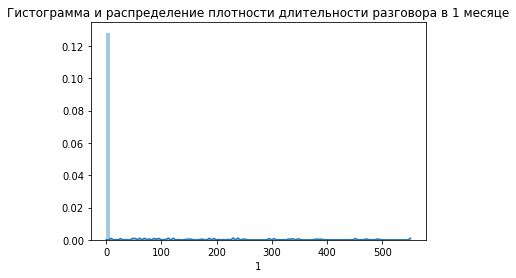

Дисперсия: 5889


count    351.000000
mean      19.746439
std       76.737483
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      551.000000
Name: 1, dtype: float64

____________________________________________________________________________________________________ Месяц: 2 



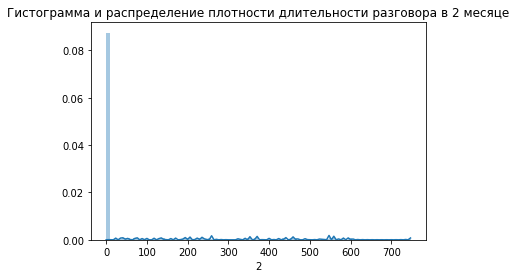

Дисперсия: 18271


count    351.000000
mean      49.356125
std      135.171367
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      747.000000
Name: 2, dtype: float64

____________________________________________________________________________________________________ Месяц: 3 



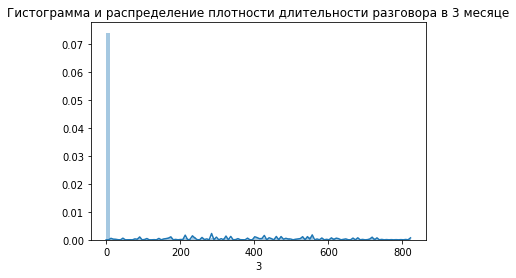

Дисперсия: 34124


count    351.000000
mean      85.566952
std      184.727306
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      822.000000
Name: 3, dtype: float64

____________________________________________________________________________________________________ Месяц: 4 



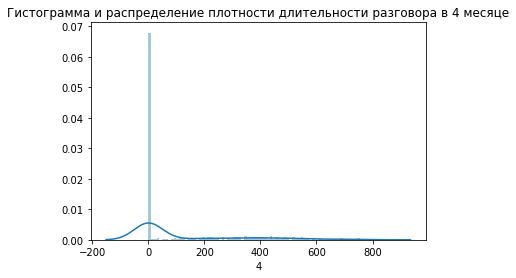

Дисперсия: 40399


count    351.000000
mean     117.148148
std      200.994288
min        0.000000
25%        0.000000
50%        0.000000
75%      206.000000
max      785.000000
Name: 4, dtype: float64

____________________________________________________________________________________________________ Месяц: 5 



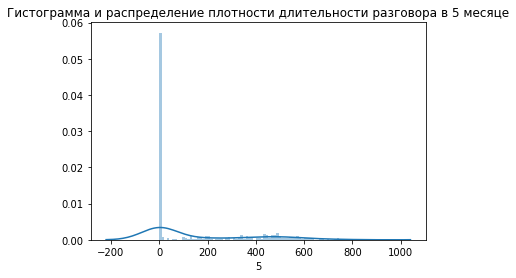

Дисперсия: 50094


count    351.000000
mean     155.606838
std      223.816224
min        0.000000
25%        0.000000
50%        0.000000
75%      345.500000
max      820.000000
Name: 5, dtype: float64

____________________________________________________________________________________________________ Месяц: 6 



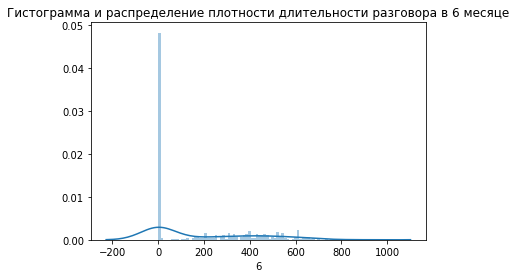

Дисперсия: 53394


count    351.000000
mean     184.857550
std      231.070372
min        0.000000
25%        0.000000
50%        0.000000
75%      387.500000
max      875.000000
Name: 6, dtype: float64

____________________________________________________________________________________________________ Месяц: 7 



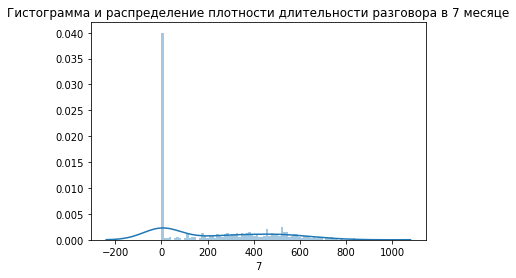

Дисперсия: 59353


count    351.000000
mean     233.843305
std      243.625323
min        0.000000
25%        0.000000
50%      183.000000
75%      454.500000
max      839.000000
Name: 7, dtype: float64

____________________________________________________________________________________________________ Месяц: 8 



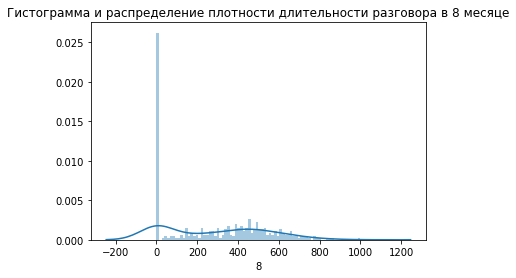

Дисперсия: 62679


count     351.000000
mean      282.179487
std       250.357103
min         0.000000
25%         0.000000
50%       289.000000
75%       487.000000
max      1000.000000
Name: 8, dtype: float64

____________________________________________________________________________________________________ Месяц: 9 



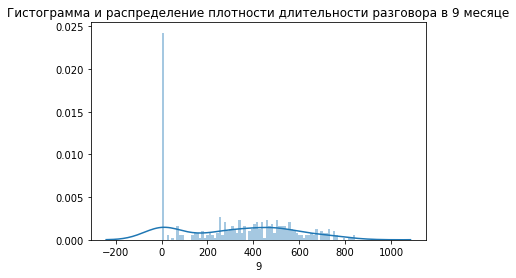

Дисперсия: 60197


count    351.000000
mean     317.490028
std      245.350616
min        0.000000
25%        0.000000
50%      338.000000
75%      508.000000
max      843.000000
Name: 9, dtype: float64

____________________________________________________________________________________________________ Месяц: 10 



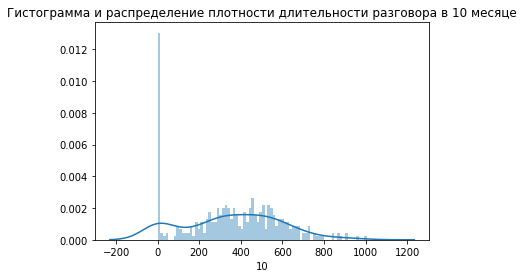

Дисперсия: 54399


count     351.000000
mean      356.934473
std       233.236884
min         0.000000
25%       194.000000
50%       365.000000
75%       530.000000
max      1005.000000
Name: 10, dtype: float64

____________________________________________________________________________________________________ Месяц: 11 



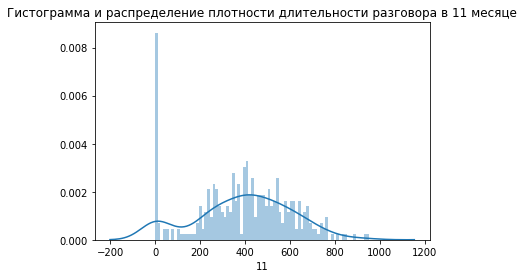

Дисперсия: 45501


count    351.000000
mean     391.863248
std      213.310059
min        0.000000
25%      264.500000
50%      407.000000
75%      539.500000
max      954.000000
Name: 11, dtype: float64

____________________________________________________________________________________________________ Месяц: 12 



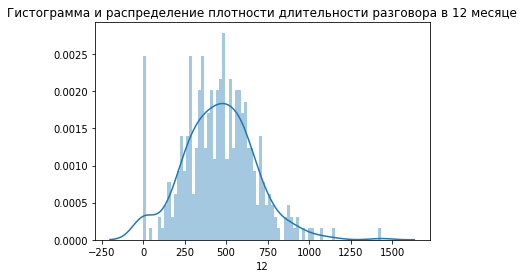

Дисперсия: 46906


count     351.000000
mean      459.472934
std       216.578178
min         0.000000
25%       320.000000
50%       464.000000
75%       593.500000
max      1435.000000
Name: 12, dtype: float64

In [90]:
calls_smart_std = [] 
calls_smart_mean = []

print('Статистика по длительности разговора за весь год. Тариф: "Смарт"\n')

for column in [str(x) for x in range(1, 13)]:
    
    calls_month = calls_sum_pivot[calls_sum_pivot['tariff'] == 'smart'][column]
    desc = calls_month.describe()
    calls_smart_mean.append(desc[1])
    calls_smart_std.append(desc[2])
    print('_' * 100, 'Месяц:', column, '\n')

    # calls_smart_month.hist(bins = 78, figsize = (12,4))
    
    sns.distplot( # по правилу Фридмана-Диакониса: 
        # bins = int(2 * (desc[6] - desc[4]) / desc[0]**(1/3)), но в 1-м месяце IQR = 0 
        
        calls_month,
        bins = 78, 
    )
    plt.title(f'Гистограмма и распределение плотности длительности разговора в {column} месяце')
    plt.show()
    
    print(f'Дисперсия: {calls_month.var():.0f}')
    display(desc)

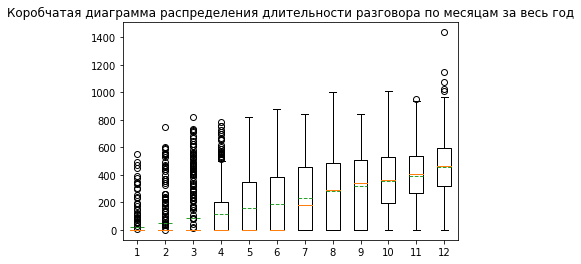

In [91]:
calls_smart_month_boxplot = []

for column in [str(x) for x in range(1, 13)]:
    
    calls_smart_month_boxplot.append(calls_sum_pivot[calls_sum_pivot['tariff'] == 'smart'][column])
    
plt.boxplot(calls_smart_month_boxplot, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)
plt.title(f'Коробчатая диаграмма распределения длительности разговора по месяцам за весь год')
plt.show()

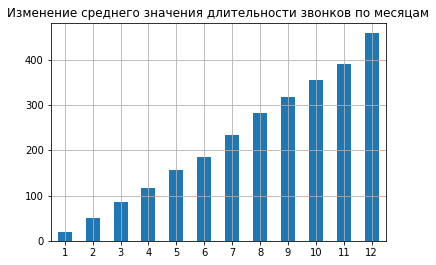

In [92]:
# Изменение среднего значения длительности звонков по месяцам

df = pd.DataFrame(calls_smart_mean)
df.index = [str(x) for x in range(1, 13)]
df.plot.bar(legend=False, grid=True, rot=1)
plt.title(f'Изменение среднего значения длительности звонков по месяцам')
plt.show()

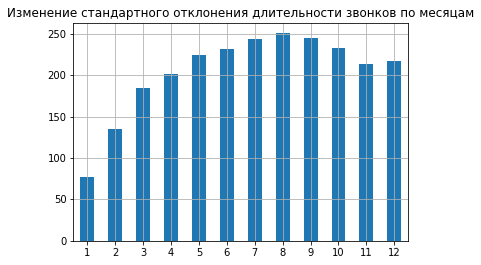

In [93]:
# Изменение стандартного отклонения длительности звонков по месяцам

df = pd.DataFrame(calls_smart_std)
df.index = [str(x) for x in range(1, 13)]
df.plot.bar(legend=False, grid=True, rot=1)
plt.title(f'Изменение стандартного отклонения длительности звонков по месяцам')
plt.show()

Видим, что в тарифе "Смарт" дисперсия и соответственно стандартное отклонение растут от месяца к месяцу, как и среднее. Очевидно это прежде всего связано с тем, что пользователей становилось с каждым месяцем больше. Распределение близко к нормальному. Дисперсия росла с ростом подключений и достигла пика на 8-м месяце, далее медленно падала из-за отрицательного баланса между подключениями и отключениями.

Чтобы оценить поведение потребителей, нам нужно сравнить показатели только тех, чья месячная длительность звонков больше 0, чтобы отсечь периоды, когда они не были подключены.

Попробуем найти достаточно большую по величине выборку подключенных пользователей в каждом тарифе. Для начала возьмем все месяцы и проверим размер выборки.

In [94]:
calls_sum_allnot0 = calls_sum_pivot[
                (~calls_sum_pivot['1'].isin([0])) &
                (~calls_sum_pivot['2'].isin([0])) &
                (~calls_sum_pivot['3'].isin([0])) &
                (~calls_sum_pivot['4'].isin([0])) &
                (~calls_sum_pivot['5'].isin([0])) &
                (~calls_sum_pivot['6'].isin([0])) &
                (~calls_sum_pivot['7'].isin([0])) &
                (~calls_sum_pivot['8'].isin([0])) &
                (~calls_sum_pivot['9'].isin([0])) &
                (~calls_sum_pivot['10'].isin([0])) &
                (~calls_sum_pivot['11'].isin([0])) &
                (~calls_sum_pivot['12'].isin([0]))
               ]

calls_sum_allnot0.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
5,1005,95,456,606,712,595,612,569,619,479,723,547,592,smart
32,1032,380,371,487,521,512,402,415,446,507,385,410,482,smart
45,1045,9,189,229,219,290,229,185,222,299,285,273,256,smart
55,1055,551,440,558,391,449,518,445,380,465,347,314,597,smart
113,1113,110,543,530,785,501,628,692,654,638,561,673,710,smart


In [95]:
len(calls_sum_allnot0)

40

Видим слишком маленькую выборку. Попробуем сузить охват по месяцам и добиться размера выборки для наименьшего по числу абонентов тарифа "Ультра" не менее 50. Уберем два первых месяца

In [96]:
calls_sum_allnot0 = calls_sum_pivot[
                #(~calls_sum_pivot['1'].isin([0])) &
                #(~calls_sum_pivot['2'].isin([0])) &
                (~calls_sum_pivot['3'].isin([0])) &
                (~calls_sum_pivot['4'].isin([0])) &
                (~calls_sum_pivot['5'].isin([0])) &
                (~calls_sum_pivot['6'].isin([0])) &
                (~calls_sum_pivot['7'].isin([0])) &
                (~calls_sum_pivot['8'].isin([0])) &
                (~calls_sum_pivot['9'].isin([0])) &
                (~calls_sum_pivot['10'].isin([0])) &
                (~calls_sum_pivot['11'].isin([0])) &
                (~calls_sum_pivot['12'].isin([0]))
               ]

calls_sum_allnot0.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
5,1005,95,456,606,712,595,612,569,619,479,723,547,592,smart
6,1006,0,42,286,356,370,478,316,275,360,267,372,379,smart
9,1009,0,0,109,324,170,289,183,249,133,213,290,229,smart
11,1011,0,0,212,371,437,327,502,515,472,630,501,361,smart
12,1012,0,0,13,345,316,219,223,157,230,451,206,356,smart


In [97]:
len(calls_sum_allnot0[calls_sum_allnot0['tariff'] == 'ultra'])

34

In [98]:
calls_sum_allnot0 = calls_sum_pivot[
                #(~calls_sum_pivot['1'].isin([0])) &
                #(~calls_sum_pivot['2'].isin([0])) &
                #(~calls_sum_pivot['3'].isin([0])) &
                (~calls_sum_pivot['4'].isin([0])) &
                (~calls_sum_pivot['5'].isin([0])) &
                (~calls_sum_pivot['6'].isin([0])) &
                (~calls_sum_pivot['7'].isin([0])) &
                (~calls_sum_pivot['8'].isin([0])) &
                (~calls_sum_pivot['9'].isin([0])) &
                (~calls_sum_pivot['10'].isin([0])) &
                (~calls_sum_pivot['11'].isin([0])) &
                (~calls_sum_pivot['12'].isin([0]))
               ]

calls_sum_allnot0.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
5,1005,95,456,606,712,595,612,569,619,479,723,547,592,smart
6,1006,0,42,286,356,370,478,316,275,360,267,372,379,smart
7,1007,0,0,0,198,480,545,577,458,655,465,580,421,smart
9,1009,0,0,109,324,170,289,183,249,133,213,290,229,smart
11,1011,0,0,212,371,437,327,502,515,472,630,501,361,smart


In [99]:
len(calls_sum_allnot0[calls_sum_allnot0['tariff'] == 'ultra'])

50

In [100]:
len(calls_sum_allnot0[calls_sum_allnot0['tariff'] == 'smart'])

106

Найден подходящий временной срез. Значит - первые 3 месяца в расчет не берем

Статистика по соверешенным звонкам с апреля по декабрь 2018. Тариф: "Смарт"

____________________________________________________________________________________________________ Месяц: 4 



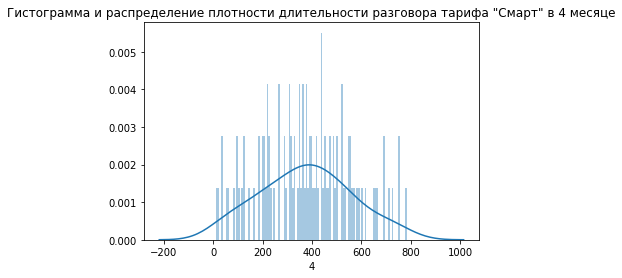

Дисперсия: 33774


count    106.000000
mean     375.283019
std      183.777182
min       11.000000
25%      230.750000
50%      378.500000
75%      498.500000
max      785.000000
Name: 4, dtype: float64

____________________________________________________________________________________________________ Месяц: 5 



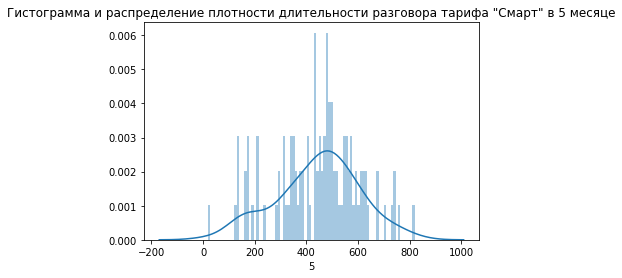

Дисперсия: 25384


count    106.000000
mean     443.811321
std      159.325131
min       19.000000
25%      345.250000
50%      466.500000
75%      549.000000
max      820.000000
Name: 5, dtype: float64

____________________________________________________________________________________________________ Месяц: 6 



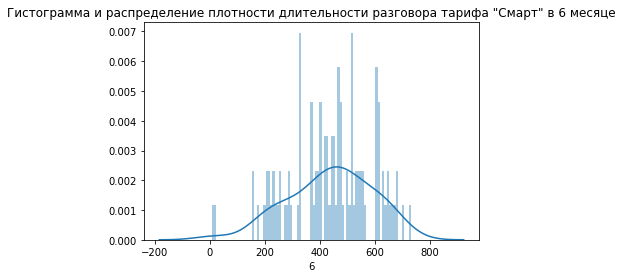

Дисперсия: 23265


count    106.000000
mean     436.650943
std      152.527096
min        7.000000
25%      329.250000
50%      449.500000
75%      541.750000
max      731.000000
Name: 6, dtype: float64

____________________________________________________________________________________________________ Месяц: 7 



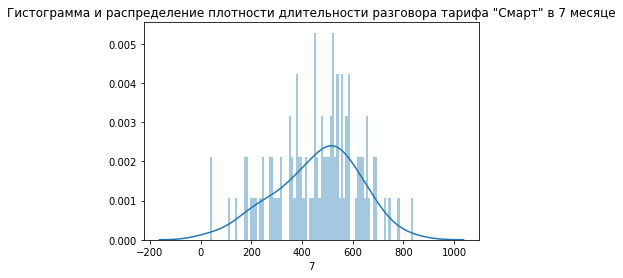

Дисперсия: 26917


count    106.000000
mean     460.084906
std      164.063990
min       36.000000
25%      360.750000
50%      483.500000
75%      575.000000
max      839.000000
Name: 7, dtype: float64

____________________________________________________________________________________________________ Месяц: 8 



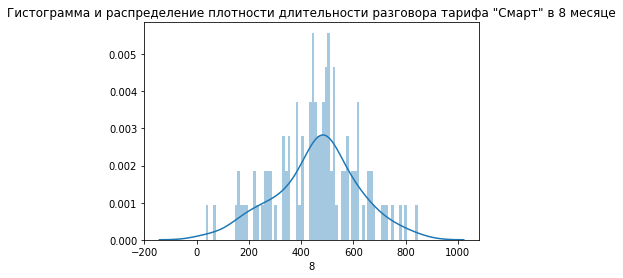

Дисперсия: 25223


count    106.000000
mean     459.792453
std      158.818898
min       34.000000
25%      363.500000
50%      474.000000
75%      554.000000
max      846.000000
Name: 8, dtype: float64

____________________________________________________________________________________________________ Месяц: 9 



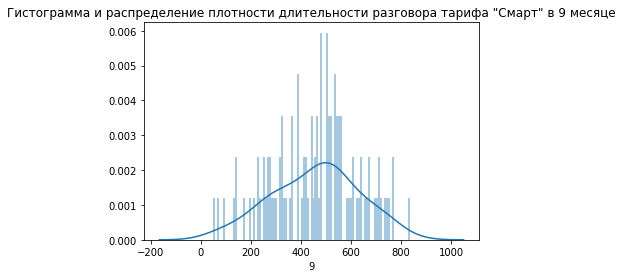

Дисперсия: 29529


count    106.000000
mean     457.839623
std      171.839080
min       50.000000
25%      324.750000
50%      475.500000
75%      559.250000
max      836.000000
Name: 9, dtype: float64

____________________________________________________________________________________________________ Месяц: 10 



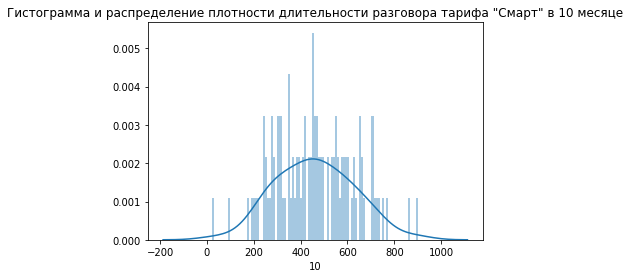

Дисперсия: 27948


count    106.000000
mean     459.528302
std      167.176565
min       22.000000
25%      335.500000
50%      457.000000
75%      576.750000
max      903.000000
Name: 10, dtype: float64

____________________________________________________________________________________________________ Месяц: 11 



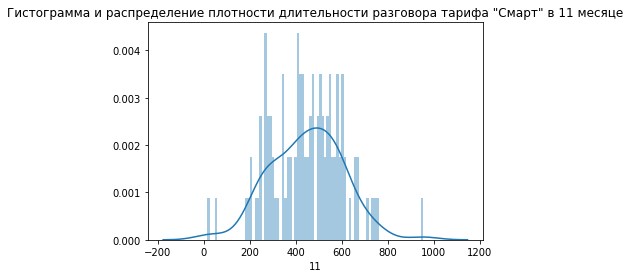

Дисперсия: 24298


count    106.000000
mean     448.094340
std      155.878984
min       16.000000
25%      347.250000
50%      452.000000
75%      554.750000
max      954.000000
Name: 11, dtype: float64

____________________________________________________________________________________________________ Месяц: 12 



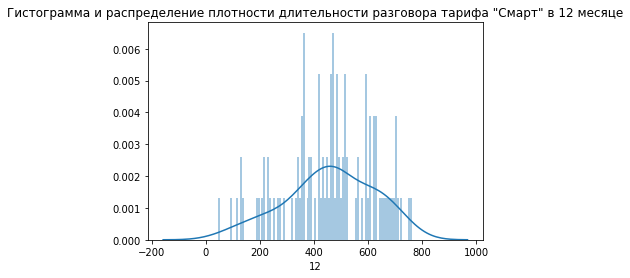

Дисперсия: 26823


count    106.000000
mean     458.301887
std      163.776978
min       46.000000
25%      359.250000
50%      467.500000
75%      594.250000
max      764.000000
Name: 12, dtype: float64

In [101]:
calls_smart_allnot0_std = [] 
calls_smart_allnot0_mean = []

print('Статистика по соверешенным звонкам с апреля по декабрь 2018. Тариф: "Смарт"\n')

for column in [str(x) for x in range(4, 13)]:
    
    calls_month = calls_sum_allnot0[calls_sum_allnot0['tariff'] == 'smart'][column]
    desc = calls_month.describe()
    calls_smart_allnot0_mean.append(desc[1])
    calls_smart_allnot0_std.append(desc[2])
    print('_' * 100, 'Месяц:', column, '\n')
    
    sns.distplot(
        calls_month,
        bins = int(2 * (desc[6] - desc[4]) / desc[0]**(1/3)),
    )
    plt.title(f'Гистограмма и распределение плотности длительности разговора тарифа "Смарт" в {column} месяце')
    plt.show()
    
    print(f'Дисперсия: {calls_month.var():.0f}')
    display(desc)

Статистика по соверешенным звонкам с апреля по декабрь 2018. Тариф: "Ультра"

____________________________________________________________________________________________________ Месяц: 4 



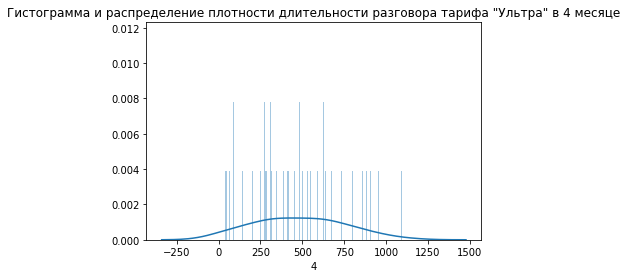

Дисперсия: 68853


count      50.000000
mean      480.420000
std       262.398753
min        41.000000
25%       285.750000
50%       485.000000
75%       665.250000
max      1096.000000
Name: 4, dtype: float64

____________________________________________________________________________________________________ Месяц: 5 



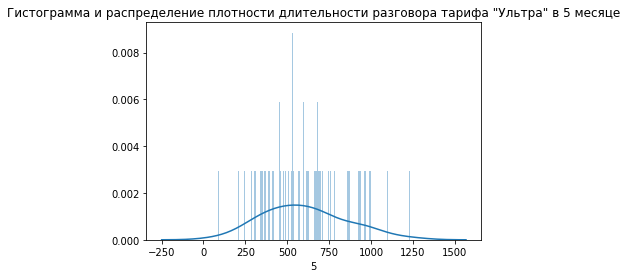

Дисперсия: 61087


count      50.000000
mean      602.880000
std       247.158104
min        86.000000
25%       427.000000
50%       582.000000
75%       738.500000
max      1232.000000
Name: 5, dtype: float64

____________________________________________________________________________________________________ Месяц: 6 



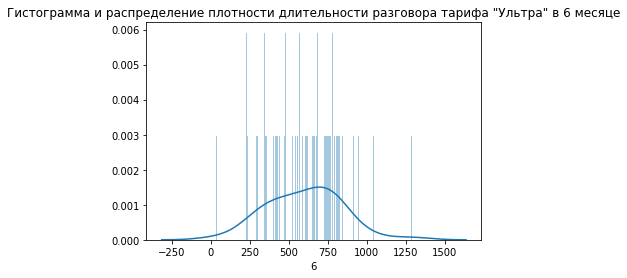

Дисперсия: 56927


count      50.000000
mean      599.920000
std       238.593484
min        31.000000
25%       421.000000
50%       614.000000
75%       765.250000
max      1290.000000
Name: 6, dtype: float64

____________________________________________________________________________________________________ Месяц: 7 



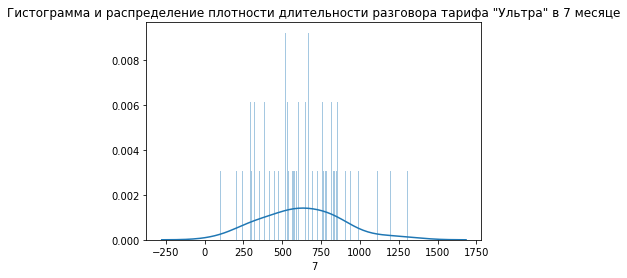

Дисперсия: 65691


count      50.000000
mean      626.880000
std       256.302965
min        96.000000
25%       457.250000
50%       607.000000
75%       803.500000
max      1311.000000
Name: 7, dtype: float64

____________________________________________________________________________________________________ Месяц: 8 



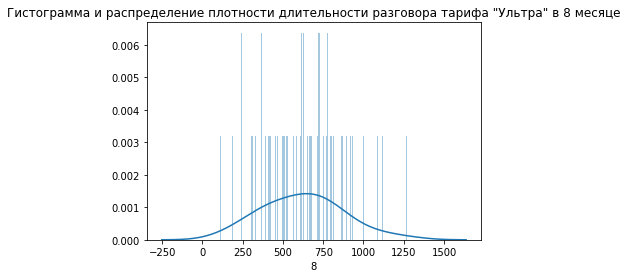

Дисперсия: 62840


count      50.000000
mean      621.540000
std       250.678688
min       112.000000
25%       429.250000
50%       623.000000
75%       771.000000
max      1273.000000
Name: 8, dtype: float64

____________________________________________________________________________________________________ Месяц: 9 



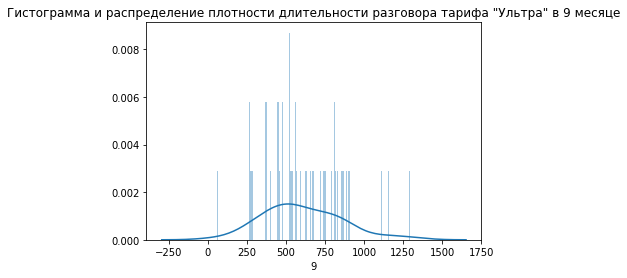

Дисперсия: 61787


count      50.000000
mean      605.380000
std       248.569613
min        62.000000
25%       447.250000
50%       561.000000
75%       778.250000
max      1297.000000
Name: 9, dtype: float64

____________________________________________________________________________________________________ Месяц: 10 



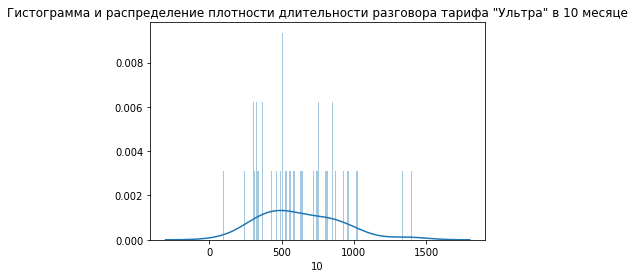

Дисперсия: 75600


count      50.000000
mean      630.300000
std       274.955006
min        98.000000
25%       439.250000
50%       574.500000
75%       814.500000
max      1401.000000
Name: 10, dtype: float64

____________________________________________________________________________________________________ Месяц: 11 



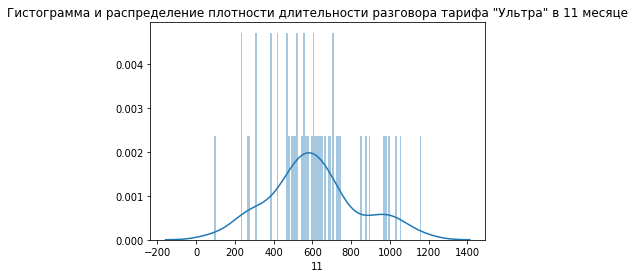

Дисперсия: 53836


count      50.000000
mean      602.540000
std       232.025527
min        93.000000
25%       475.250000
50%       587.500000
75%       708.750000
max      1161.000000
Name: 11, dtype: float64

____________________________________________________________________________________________________ Месяц: 12 



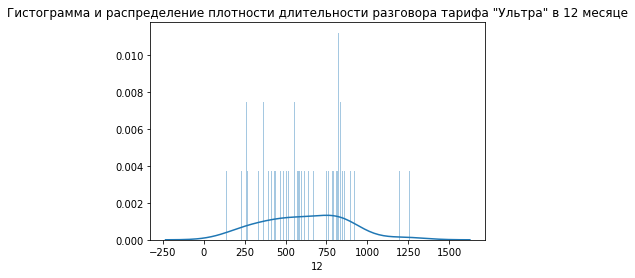

Дисперсия: 64280


count      50.000000
mean      617.240000
std       253.534892
min       134.000000
25%       432.250000
50%       605.000000
75%       820.250000
max      1259.000000
Name: 12, dtype: float64

In [102]:
calls_ultra_allnot0_std = [] 
calls_ultra_allnot0_mean = []

print('Статистика по соверешенным звонкам с апреля по декабрь 2018. Тариф: "Ультра"\n')

for column in [str(x) for x in range(4, 13)]:
    
    calls_month = calls_sum_allnot0[calls_sum_allnot0['tariff'] == 'ultra'][column]
    desc = calls_month.describe()
    calls_ultra_allnot0_mean.append(desc[1])
    calls_ultra_allnot0_std.append(desc[2])
    print('_' * 100, 'Месяц:', column, '\n')
       
    sns.distplot(
        calls_month,
        bins = int(2 * (desc[6] - desc[4]) / desc[0]**(1/3)),
    )
    plt.title(f'Гистограмма и распределение плотности длительности разговора тарифа "Ультра" в {column} месяце')
    plt.show()
    
    print(f'Дисперсия: {calls_month.var():.0f}')
    display(desc)

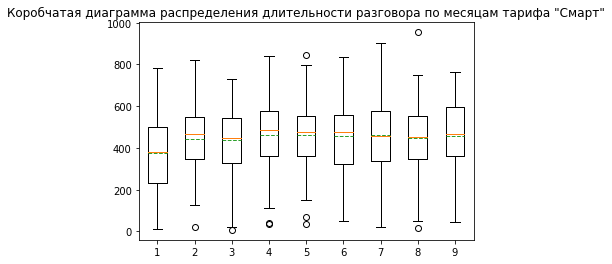

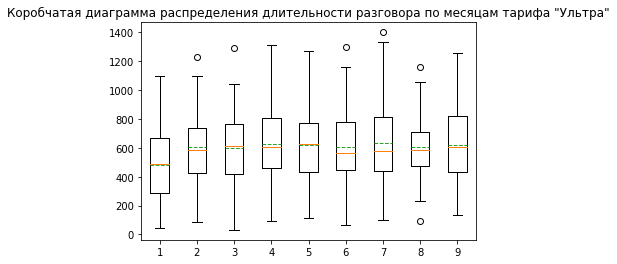

In [103]:
calls_smart_month_boxplot = []

for column in [str(x) for x in range(4, 13)]:
    calls_smart_month_boxplot.append(calls_sum_allnot0[calls_sum_allnot0['tariff'] == 'smart'][column])
    
plt.boxplot(calls_smart_month_boxplot, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)
plt.title(f'Коробчатая диаграмма распределения длительности разговора по месяцам тарифа "Смарт"')
plt.show()

calls_ultra_month_boxplot = []

for column in [str(x) for x in range(4, 13)]:
    calls_ultra_month_boxplot.append(calls_sum_allnot0[calls_sum_allnot0['tariff'] == 'ultra'][column])
    
plt.boxplot(calls_ultra_month_boxplot, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)
plt.title(f'Коробчатая диаграмма распределения длительности разговора по месяцам тарифа "Ультра"')
plt.show()

Изменение среднего значения длительности звонков по месяцам

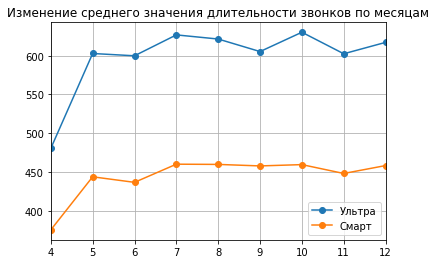

Среднее значение длительности звонков
Тариф "Смарт": [444.0]
Тариф "Ультра": [599.0]


In [104]:
df1 = pd.DataFrame(calls_ultra_allnot0_mean)
df1.index = [str(x) for x in range(4, 13)]
ax = df1.plot(style='o-', grid=True, label = 'Ультра')

df2 = pd.DataFrame(calls_smart_allnot0_mean)
df2.index = [str(x) for x in range(4, 13)]
df2.plot(style='o-', grid=True, label = 'Смарт', ax=ax)

plt.title(f'Изменение среднего значения длительности звонков по месяцам')
plt.legend(['Ультра', 'Смарт'])
plt.show()

print(f'Среднее значение длительности звонков')
print(f'Тариф "Смарт": {df2.mean().round().to_list()}')
print(f'Тариф "Ультра": {df1.mean().round().to_list()}')

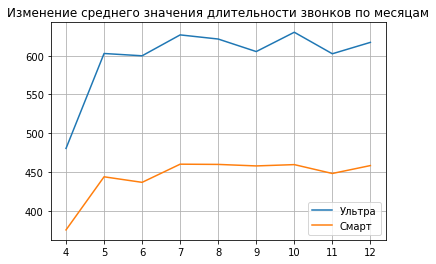

Среднее значение длительности звонков
Тариф "Смарт": [444.0]
Тариф "Ультра": [599.0]


In [105]:
df1 = pd.DataFrame(calls_ultra_allnot0_mean)
df1.index = [str(x) for x in range(4, 13)]

df2 = pd.DataFrame(calls_smart_allnot0_mean)
df2.index = [str(x) for x in range(4, 13)]

fig, ax = plt.subplots()

ax.plot(df1, label = 'Ультра')
ax.plot(df2, label = 'Смарт')

plt.title('Изменение среднего значения длительности звонков по месяцам')
plt.legend()
plt.grid()
plt.show()

print(f'Среднее значение длительности звонков')
print(f'Тариф "Смарт": {df2.mean().round().to_list()}')
print(f'Тариф "Ультра": {df1.mean().round().to_list()}')

Изменение стандартного отклонения длительности звонков по месяцам

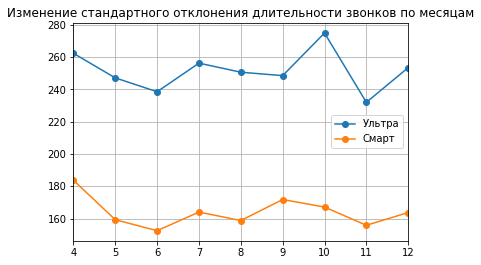

Среднее стандартное отклонение длительности звонков
Тариф "Смарт": [164.0]
Тариф "Ультра": [252.0]


In [106]:
df1 = pd.DataFrame(calls_ultra_allnot0_std)
df1.index = [str(x) for x in range(4, 13)]
ax = df1.plot(style='o-', legend=False, grid=True, rot=1)

df2 = pd.DataFrame(calls_smart_allnot0_std)
df2.index = [str(x) for x in range(4, 13)]
df2.plot(style='o-', legend=False, grid=True, rot=1, ax=ax)

plt.title('Изменение стандартного отклонения длительности звонков по месяцам')
plt.legend(['Ультра', 'Смарт'])
plt.show()

print(f'Среднее стандартное отклонение длительности звонков')
print(f'Тариф "Смарт": {df2.mean().round().to_list()}')
print(f'Тариф "Ультра": {df1.mean().round().to_list()}')

Видим распределение, близкое к нормальному. На тарифе "Смарт" мат. ожидание в 500 (входят в аб. плату) и очень небольшой в районе 200. На тарифе "Ультра", где в бесплатный пакет входят 3000 минут, видим мат. ожидание 600 и небольшой пик в 1000, максимум составляет 1400 минут. Поэтому предложение в 3000 бесплатных минут для этого тарифа выглядит явно избыточным. И требуется создать еще один с ограничением в 1500 минут.

### Распределение количества сообщений sms

In [107]:
messages_count_pivot.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,0,0,0,0,22,60,75,81,57,73,58,70,ultra
1,1001,0,0,0,0,0,0,0,0,0,0,0,0,smart
2,1002,0,0,0,0,0,4,11,13,4,10,16,12,smart
3,1003,0,0,0,0,0,0,0,37,91,83,94,75,ultra
4,1004,0,0,0,0,95,134,181,151,146,165,158,162,ultra


In [108]:
messages_allnot0 = messages_count_pivot[
                #(~calls_sum_pivot['1'].isin([0])) &
                #(~calls_sum_pivot['2'].isin([0])) &
                #(~calls_sum_pivot['3'].isin([0])) &
                (~messages_count_pivot['4'].isin([0])) &
                (~messages_count_pivot['5'].isin([0])) &
                (~messages_count_pivot['6'].isin([0])) &
                (~messages_count_pivot['7'].isin([0])) &
                (~messages_count_pivot['8'].isin([0])) &
                (~messages_count_pivot['9'].isin([0])) &
                (~messages_count_pivot['10'].isin([0])) &
                (~messages_count_pivot['11'].isin([0])) &
                (~messages_count_pivot['12'].isin([0]))
               ]

messages_allnot0.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
5,1005,7,38,56,41,42,47,56,64,52,44,51,54,smart
7,1007,0,0,0,11,39,26,26,27,31,18,21,26,smart
9,1009,0,0,2,14,7,14,14,9,12,15,11,12,smart
11,1011,0,0,4,7,13,13,13,15,10,17,12,6,smart
12,1012,0,0,2,21,10,15,12,23,14,13,25,15,smart


In [109]:
len(messages_allnot0[messages_allnot0['tariff'] == 'ultra'])

38

In [110]:
len(messages_allnot0[messages_allnot0['tariff'] == 'smart'])

92

Статистика по отправленным сообщениям с апреля по декабрь 2018. Тариф: "Смарт"

____________________________________________________________________________________________________ Месяц: 4 



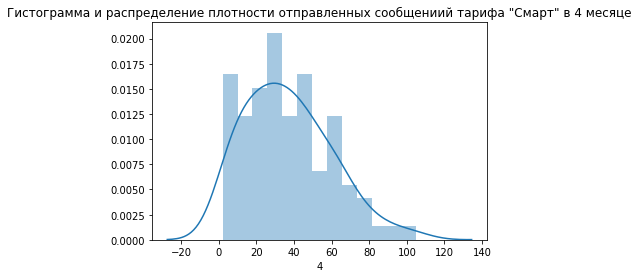

Дисперсия: 525


count     92.000000
mean      36.641304
std       22.920590
min        2.000000
25%       19.000000
50%       33.000000
75%       50.000000
max      105.000000
Name: 4, dtype: float64

____________________________________________________________________________________________________ Месяц: 5 



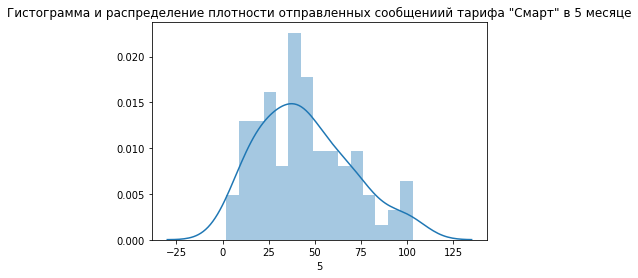

Дисперсия: 616


count     92.000000
mean      44.532609
std       24.820433
min        2.000000
25%       26.750000
50%       42.000000
75%       61.000000
max      103.000000
Name: 5, dtype: float64

____________________________________________________________________________________________________ Месяц: 6 



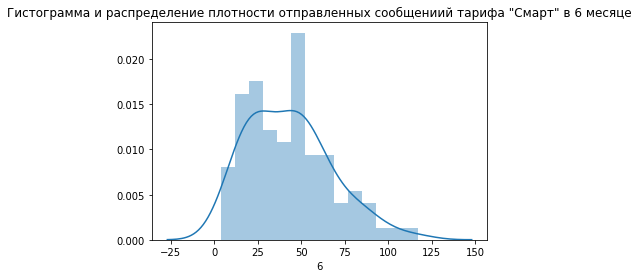

Дисперсия: 583


count     92.000000
mean      42.880435
std       24.146004
min        4.000000
25%       23.000000
50%       40.000000
75%       56.250000
max      117.000000
Name: 6, dtype: float64

____________________________________________________________________________________________________ Месяц: 7 



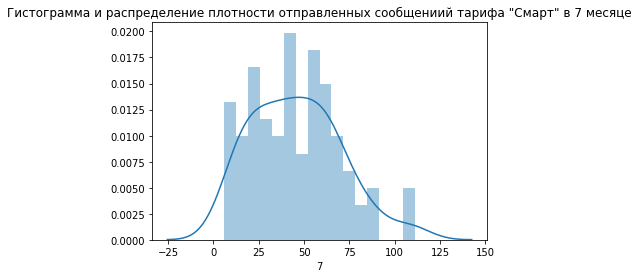

Дисперсия: 599


count     92.000000
mean      45.706522
std       24.466859
min        6.000000
25%       25.000000
50%       43.000000
75%       62.250000
max      111.000000
Name: 7, dtype: float64

____________________________________________________________________________________________________ Месяц: 8 



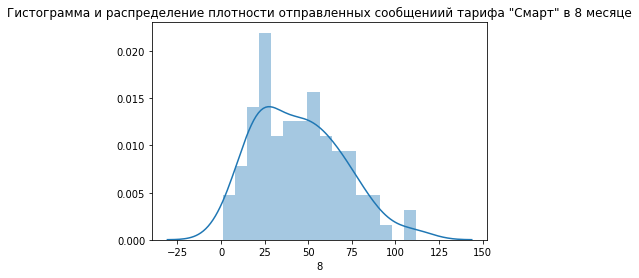

Дисперсия: 611


count     92.000000
mean      44.369565
std       24.722512
min        1.000000
25%       24.000000
50%       42.500000
75%       62.250000
max      112.000000
Name: 8, dtype: float64

____________________________________________________________________________________________________ Месяц: 9 



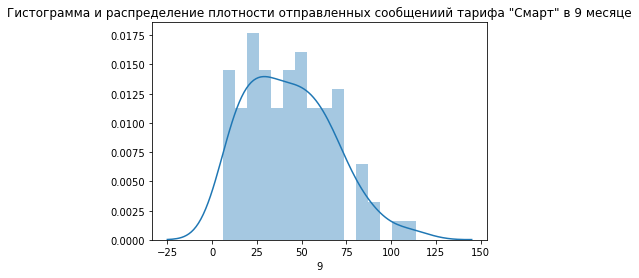

Дисперсия: 583


count     92.000000
mean      42.913043
std       24.143642
min        6.000000
25%       21.750000
50%       42.000000
75%       59.000000
max      114.000000
Name: 9, dtype: float64

____________________________________________________________________________________________________ Месяц: 10 



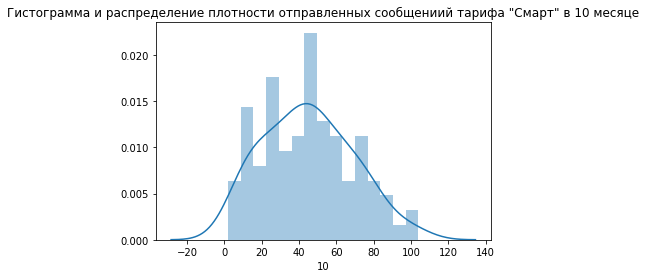

Дисперсия: 564


count     92.000000
mean      44.836957
std       23.749738
min        2.000000
25%       26.000000
50%       44.000000
75%       62.000000
max      104.000000
Name: 10, dtype: float64

____________________________________________________________________________________________________ Месяц: 11 



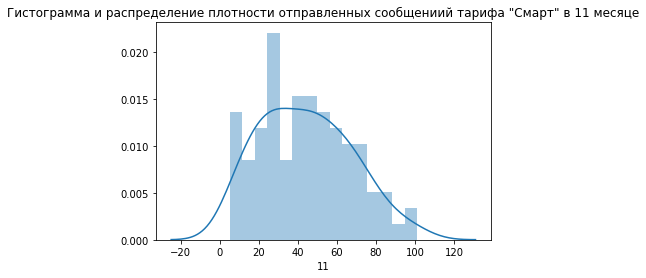

Дисперсия: 541


count     92.000000
mean      43.836957
std       23.260246
min        5.000000
25%       26.000000
50%       42.500000
75%       60.250000
max      101.000000
Name: 11, dtype: float64

____________________________________________________________________________________________________ Месяц: 12 



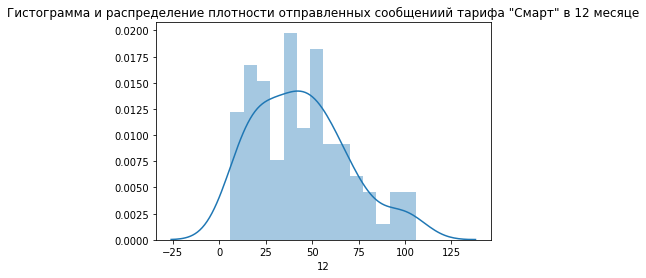

Дисперсия: 620


count     92.000000
mean      43.967391
std       24.902646
min        6.000000
25%       24.750000
50%       41.000000
75%       58.250000
max      106.000000
Name: 12, dtype: float64

In [111]:
messages_smart_allnot0_std = [] 
messages_smart_allnot0_mean = []

print('Статистика по отправленным сообщениям с апреля по декабрь 2018. Тариф: "Смарт"\n')

for column in [str(x) for x in range(4, 13)]:
    
    messages_month = messages_allnot0[messages_allnot0['tariff'] == 'smart'][column]
    desc = messages_month.describe()
    messages_smart_allnot0_mean.append(desc[1])
    messages_smart_allnot0_std.append(desc[2])
    print('_' * 100, 'Месяц:', column, '\n')
        
    sns.distplot(
        messages_month,
        bins = int(2 * (desc[6] - desc[4]) / desc[0]**(1/3)),
    )
    plt.title(f'Гистограмма и распределение плотности отправленных сообщениий тарифа "Смарт" в {column} месяце')
    plt.show()
    
    print(f'Дисперсия: {messages_month.var():.0f}')
    display(desc)

Статистика по отправленным сообщениям с апреля по декабрь 2018. Тариф: "Ультра"

____________________________________________________________________________________________________ Месяц: 4 



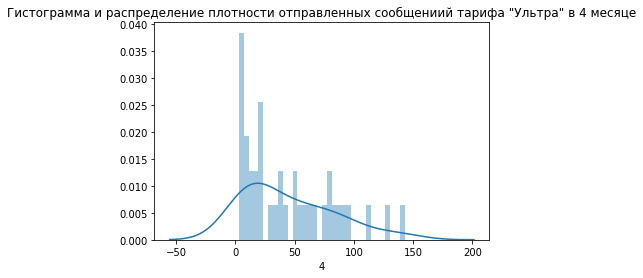

Дисперсия: 1443


count     38.000000
mean      44.815789
std       37.982112
min        3.000000
25%       13.250000
50%       37.000000
75%       71.000000
max      143.000000
Name: 4, dtype: float64

____________________________________________________________________________________________________ Месяц: 5 



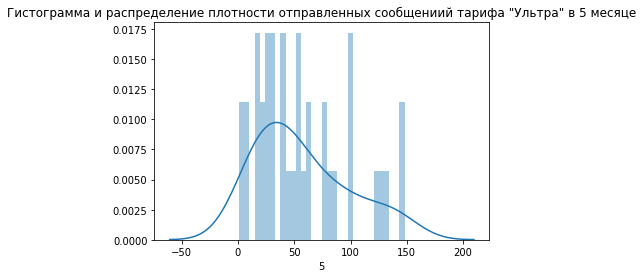

Дисперсия: 1698


count     38.000000
mean      56.868421
std       41.210843
min        1.000000
25%       26.250000
50%       47.500000
75%       80.500000
max      148.000000
Name: 5, dtype: float64

____________________________________________________________________________________________________ Месяц: 6 



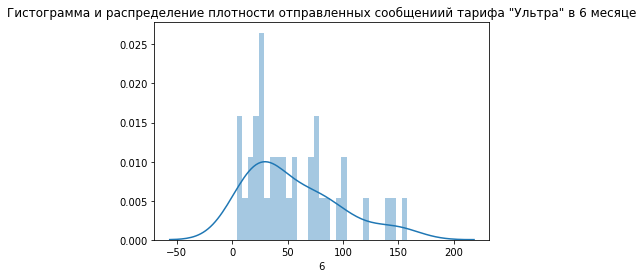

Дисперсия: 1686


count     38.000000
mean      54.815789
std       41.055569
min        4.000000
25%       24.250000
50%       42.000000
75%       77.250000
max      158.000000
Name: 6, dtype: float64

____________________________________________________________________________________________________ Месяц: 7 



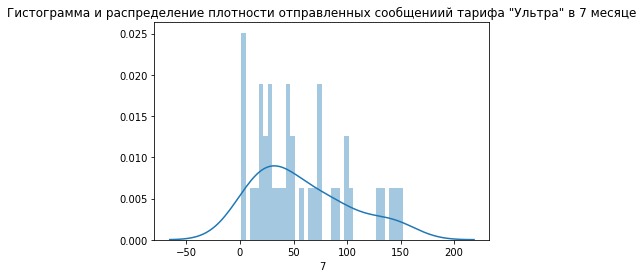

Дисперсия: 1882


count     38.000000
mean      57.500000
std       43.383737
min        1.000000
25%       24.250000
50%       46.500000
75%       85.750000
max      152.000000
Name: 7, dtype: float64

____________________________________________________________________________________________________ Месяц: 8 



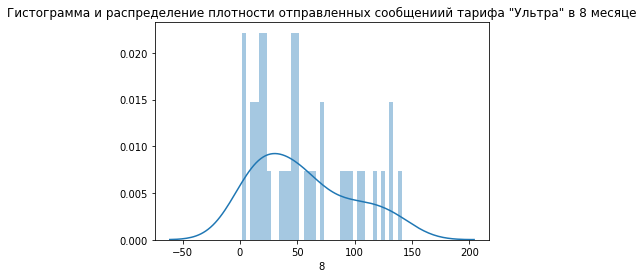

Дисперсия: 1697


count     38.000000
mean      54.684211
std       41.191120
min        2.000000
25%       19.250000
50%       47.500000
75%       85.500000
max      141.000000
Name: 8, dtype: float64

____________________________________________________________________________________________________ Месяц: 9 



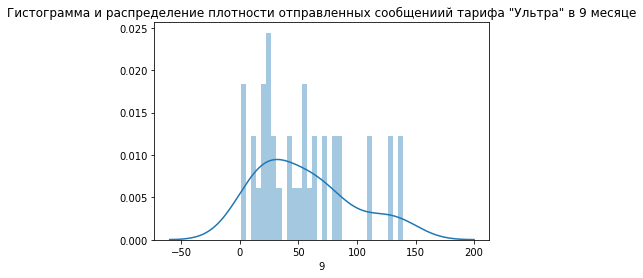

Дисперсия: 1581


count     38.000000
mean      54.526316
std       39.757193
min        1.000000
25%       23.250000
50%       49.000000
75%       77.750000
max      139.000000
Name: 9, dtype: float64

____________________________________________________________________________________________________ Месяц: 10 



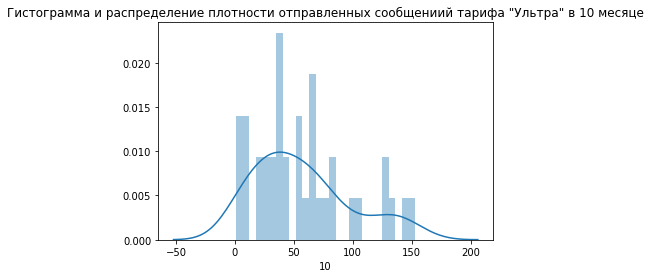

Дисперсия: 1693


count     38.000000
mean      56.815789
std       41.145658
min        1.000000
25%       28.500000
50%       48.500000
75%       75.250000
max      153.000000
Name: 10, dtype: float64

____________________________________________________________________________________________________ Месяц: 11 



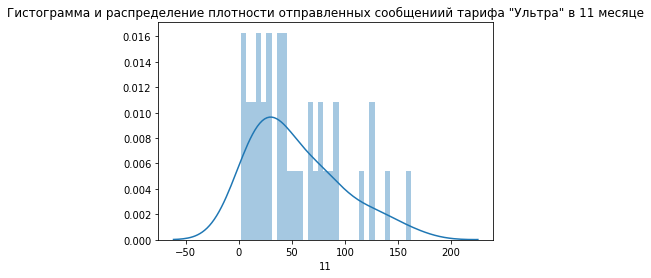

Дисперсия: 1701


count     38.000000
mean      53.736842
std       41.249199
min        2.000000
25%       21.250000
50%       41.500000
75%       78.250000
max      162.000000
Name: 11, dtype: float64

____________________________________________________________________________________________________ Месяц: 12 



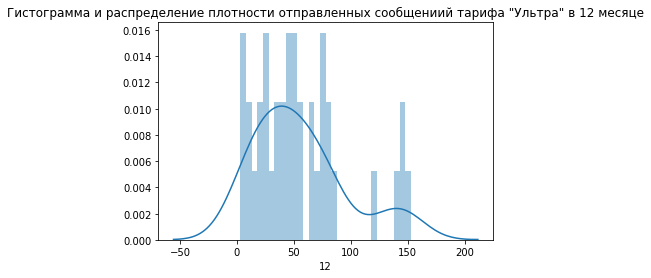

Дисперсия: 1660


count     38.000000
mean      55.289474
std       40.742373
min        3.000000
25%       23.250000
50%       47.500000
75%       74.750000
max      153.000000
Name: 12, dtype: float64

In [112]:
messages_ultra_allnot0_std = [] 
messages_ultra_allnot0_mean = []

print('Статистика по отправленным сообщениям с апреля по декабрь 2018. Тариф: "Ультра"\n')

for column in [str(x) for x in range(4, 13)]:
    
    messages_month = messages_allnot0[messages_allnot0['tariff'] == 'ultra'][column]
    desc = messages_month.describe()
    messages_ultra_allnot0_mean.append(desc[1])
    messages_ultra_allnot0_std.append(desc[2])
    print('_' * 100, 'Месяц:', column, '\n')
        
    sns.distplot(
        messages_month,
        bins = int(2 * (desc[6] - desc[4]) / desc[0]**(1/3)),
    )
    
    plt.title(f'Гистограмма и распределение плотности отправленных сообщениий тарифа "Ультра" в {column} месяце')
    plt.show()
    
    print(f'Дисперсия: {messages_month.var():.0f}')
    display(desc)

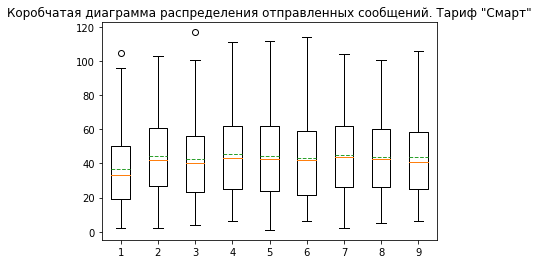

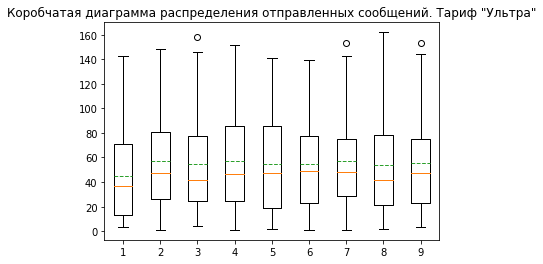

In [113]:
messages_smart_month_boxplot = []

for column in [str(x) for x in range(4, 13)]:
    messages_smart_month_boxplot.append(messages_allnot0[messages_allnot0['tariff'] == 'smart'][column])
    
plt.boxplot(messages_smart_month_boxplot, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)
plt.title('Коробчатая диаграмма распределения отправленных сообщений. Тариф "Смарт"')
plt.show()

messages_ultra_month_boxplot = []

for column in [str(x) for x in range(4, 13)]:
    messages_ultra_month_boxplot.append(messages_allnot0[messages_allnot0['tariff'] == 'ultra'][column])
    
plt.boxplot(messages_ultra_month_boxplot, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)
plt.title('Коробчатая диаграмма распределения отправленных сообщений. Тариф "Ультра"')
plt.show()

Изменение среднего значения отправленных сообщений по месяцам

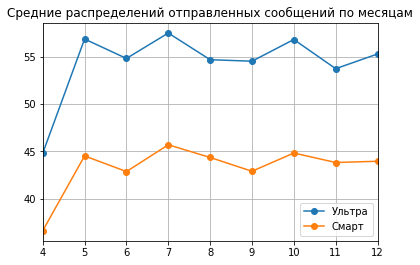

Среднее значение отправленных сообщений
Тариф "Смарт": [43.0]
Тариф "Ультра": [54.0]


In [114]:
df1 = pd.DataFrame(messages_ultra_allnot0_mean)
df1.index = [str(x) for x in range(4, 13)]
ax = df1.plot(style='o-', legend=False, grid=True, rot=1)

df2 = pd.DataFrame(messages_smart_allnot0_mean)
df2.index = [str(x) for x in range(4, 13)]
df2.plot(style='o-', legend=False, grid=True, rot=1, ax=ax)

plt.legend(['Ультра', 'Смарт'])
plt.title('Средние распределений отправленных сообщений по месяцам')
plt.show()

print(f'Среднее значение отправленных сообщений')
print(f'Тариф "Смарт": {df2.mean().round().to_list()}')
print(f'Тариф "Ультра": {df1.mean().round().to_list()}')

Изменение стандартного отклонения распределений отправленных сообщений по месяцам

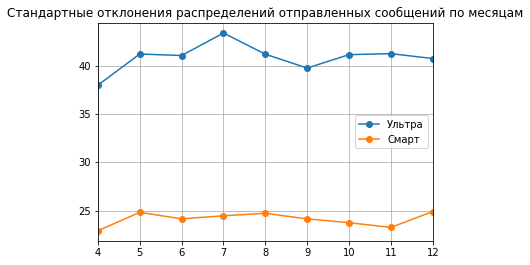

Среднее стандартное отклонение отправленных сообщений
Тариф "Смарт": [24.0]
Тариф "Ультра": [41.0]


In [115]:
df1 = pd.DataFrame(messages_ultra_allnot0_std)
df1.index = [str(x) for x in range(4, 13)]
ax = df1.plot(style='o-', legend=False, grid=True, rot=1)

df2 = pd.DataFrame(messages_smart_allnot0_std)
df2.index = [str(x) for x in range(4, 13)]
df2.plot(style='o-', legend=False, grid=True, rot=1, ax=ax)

plt.legend(['Ультра', 'Смарт'])
plt.title('Стандартные отклонения распределений отправленных сообщений по месяцам')
plt.show()

print(f'Среднее стандартное отклонение отправленных сообщений')
print(f'Тариф "Смарт": {df2.mean().round().to_list()}')
print(f'Тариф "Ультра": {df1.mean().round().to_list()}')

Видим распределение Пуассона, что вполне закономерно. На тарифе "Смарт" мат. ожидания в двух примерно одинаковых пиках 25 и 50 (входят в аб. плату) и очень небольшой в районе 100. На тарифе "Ультра", где бесплатные 1000 сообщений, видим мат. ожидание в те же 50, что и на "Смарте" плюс небольшой пик на 140, максимум составляет 162 сообщения. Поэтому предложение в 1000 бесплатных смс для этого тарифа выглядит явно избыточным, по-видимому это как безлимит, только с разумным ограничением. Это говорит о том, что предложение о бесплатных сообщениях нужно поделить на 3 тарифа: 50, 100 и 1000 смс. 

### Распределение трафика интернет

In [116]:
internet_sum_pivot_gb.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,0,0,0,0,3,23,14,14,15,15,15,10,ultra
1,1001,0,0,0,0,0,0,0,0,0,0,18,14,smart
2,1002,0,0,0,0,0,11,18,20,17,14,19,18,smart
3,1003,0,0,0,0,0,0,0,9,13,15,12,10,ultra
4,1004,0,0,0,0,14,18,22,28,15,19,16,18,ultra


In [117]:
internet_allnot0 = internet_sum_pivot_gb[
                #(~calls_sum_pivot['1'].isin([0])) &
                #(~calls_sum_pivot['2'].isin([0])) &
                #(~calls_sum_pivot['3'].isin([0])) &
                (~internet_sum_pivot['4'].isin([0])) &
                (~internet_sum_pivot['5'].isin([0])) &
                (~internet_sum_pivot['6'].isin([0])) &
                (~internet_sum_pivot['7'].isin([0])) &
                (~internet_sum_pivot['8'].isin([0])) &
                (~internet_sum_pivot['9'].isin([0])) &
                (~internet_sum_pivot['10'].isin([0])) &
                (~internet_sum_pivot['11'].isin([0])) &
                (~internet_sum_pivot['12'].isin([0]))
               ]

internet_allnot0.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
5,1005,3,8,11,10,8,10,8,8,7,8,13,9,smart
6,1006,0,2,17,14,13,13,20,19,16,20,13,19,smart
7,1007,0,0,0,8,18,14,16,21,13,15,16,13,smart
9,1009,0,0,8,15,14,16,25,24,22,20,17,19,smart
11,1011,0,0,6,18,18,17,19,21,22,18,25,23,smart


In [118]:
len(internet_allnot0[internet_allnot0['tariff'] == 'ultra'])

52

In [119]:
len(internet_allnot0[internet_allnot0['tariff'] == 'smart'])

107

Статистика по интернет-трафику с апреля по декабрь 2018. Тариф: "Смарт"

____________________________________________________________________________________________________ Месяц: 4 



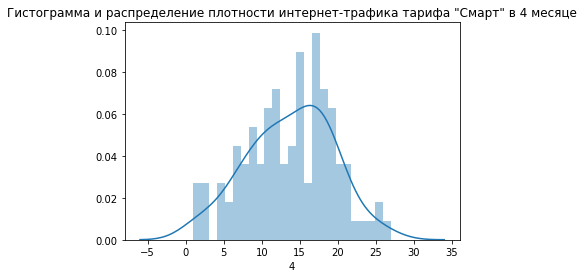

Дисперсия: 32


count    107.000000
mean      13.710280
std        5.625094
min        1.000000
25%       10.000000
50%       14.000000
75%       18.000000
max       27.000000
Name: 4, dtype: float64

____________________________________________________________________________________________________ Месяц: 5 



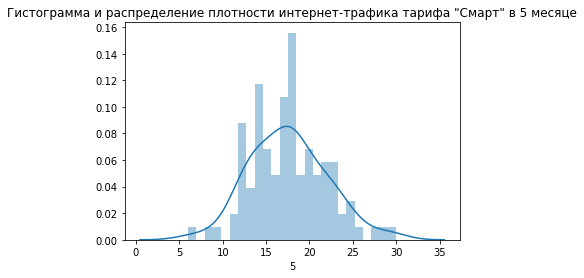

Дисперсия: 20


count    107.000000
mean      17.560748
std        4.434380
min        6.000000
25%       14.000000
50%       18.000000
75%       20.000000
max       30.000000
Name: 5, dtype: float64

____________________________________________________________________________________________________ Месяц: 6 



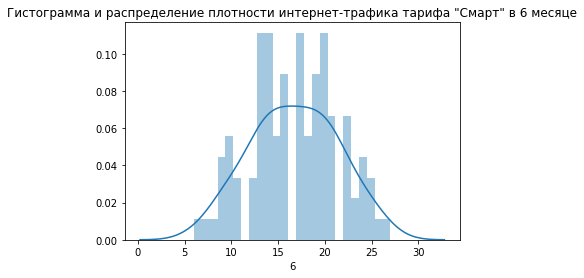

Дисперсия: 21


count    107.000000
mean      16.719626
std        4.627225
min        6.000000
25%       13.000000
50%       17.000000
75%       20.000000
max       27.000000
Name: 6, dtype: float64

____________________________________________________________________________________________________ Месяц: 7 



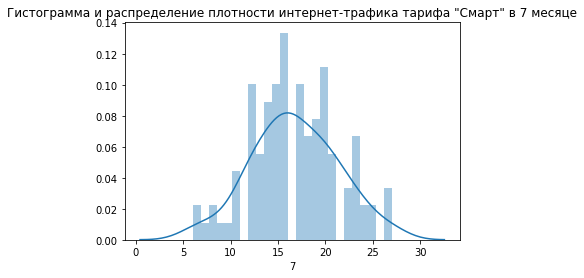

Дисперсия: 21


count    107.000000
mean      16.747664
std        4.555928
min        6.000000
25%       14.000000
50%       16.000000
75%       20.000000
max       27.000000
Name: 7, dtype: float64

____________________________________________________________________________________________________ Месяц: 8 



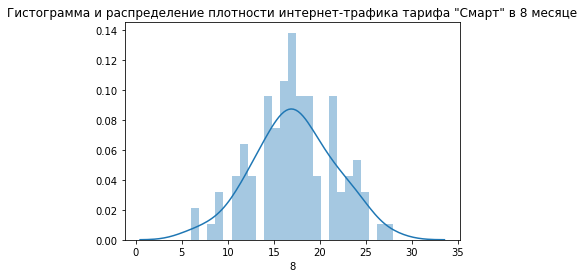

Дисперсия: 20


count    107.000000
mean      17.168224
std        4.441413
min        6.000000
25%       14.000000
50%       17.000000
75%       20.000000
max       28.000000
Name: 8, dtype: float64

____________________________________________________________________________________________________ Месяц: 9 



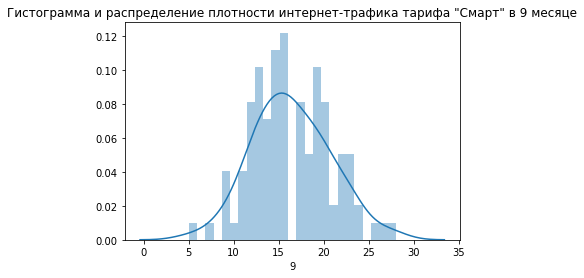

Дисперсия: 19


count    107.000000
mean      16.401869
std        4.330366
min        5.000000
25%       13.000000
50%       16.000000
75%       19.000000
max       28.000000
Name: 9, dtype: float64

____________________________________________________________________________________________________ Месяц: 10 



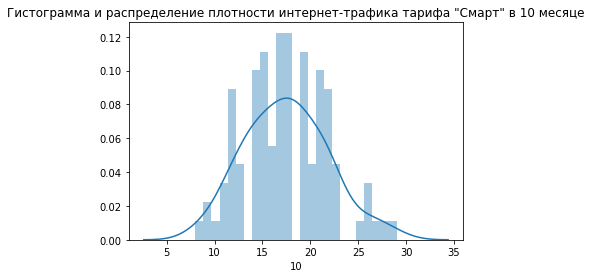

Дисперсия: 19


count    107.000000
mean      17.495327
std        4.318398
min        8.000000
25%       14.000000
50%       17.000000
75%       21.000000
max       29.000000
Name: 10, dtype: float64

____________________________________________________________________________________________________ Месяц: 11 



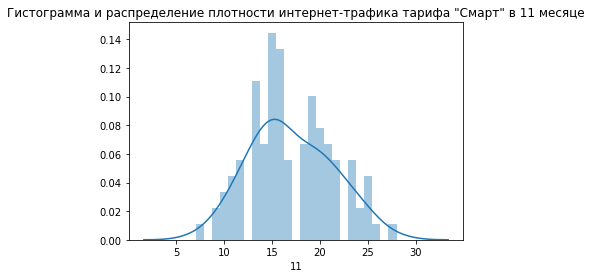

Дисперсия: 19


count    107.000000
mean      16.981308
std        4.326272
min        7.000000
25%       14.000000
50%       16.000000
75%       20.000000
max       28.000000
Name: 11, dtype: float64

____________________________________________________________________________________________________ Месяц: 12 



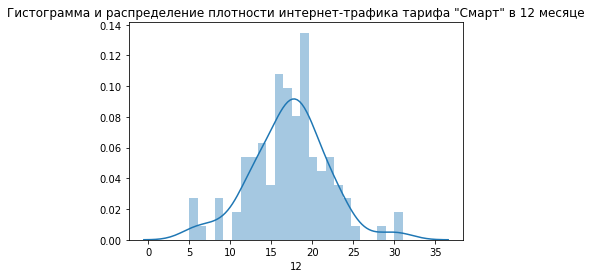

Дисперсия: 21


count    107.000000
mean      17.214953
std        4.633813
min        5.000000
25%       14.000000
50%       17.000000
75%       20.000000
max       31.000000
Name: 12, dtype: float64

In [120]:
internet_smart_allnot0_std = [] 
internet_smart_allnot0_mean = []

print('Статистика по интернет-трафику с апреля по декабрь 2018. Тариф: "Смарт"\n')

for column in [str(x) for x in range(4, 13)]:
    
    internet_month = internet_allnot0[internet_allnot0['tariff'] == 'smart'][column]
    desc = internet_month.describe()
    internet_smart_allnot0_mean.append(desc[1])
    internet_smart_allnot0_std.append(desc[2])
    print('_' * 100, 'Месяц:', column, '\n')
        
    sns.distplot(
        internet_month,
        #bins = int(2 * (desc[6] - desc[4]) / desc[0]**(1/3)),
        bins = 25,
    )
    
    plt.title(f'Гистограмма и распределение плотности интернет-трафика тарифа "Смарт" в {column} месяце')
    plt.show()
    
    print(f'Дисперсия: {internet_month.var():.0f}')
    display(desc)

Статистика по интернет-трафику с апреля по декабрь 2018. Тариф: "Ультра"

____________________________________________________________________________________________________ Месяц: 4 



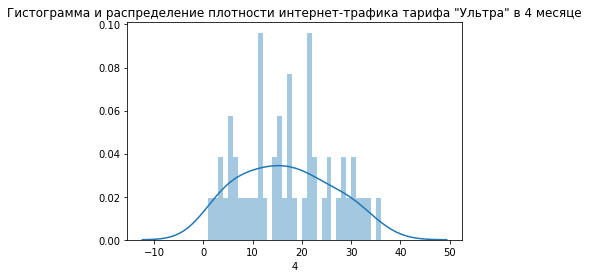

Дисперсия: 87


count    52.000000
mean     16.596154
std       9.305827
min       1.000000
25%       9.750000
50%      16.500000
75%      22.500000
max      36.000000
Name: 4, dtype: float64

____________________________________________________________________________________________________ Месяц: 5 



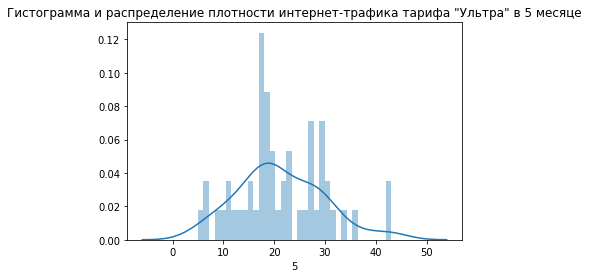

Дисперсия: 71


count    52.000
mean     21.250
std       8.434
min       5.000
25%      16.750
50%      20.000
75%      27.000
max      43.000
Name: 5, dtype: float64

____________________________________________________________________________________________________ Месяц: 6 



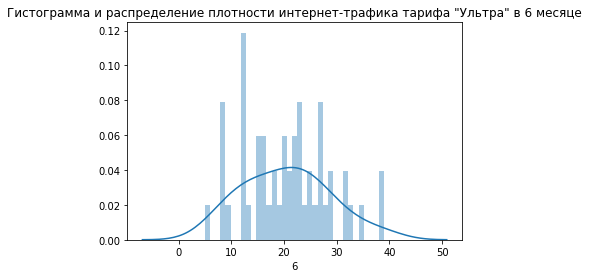

Дисперсия: 68


count    52.000000
mean     20.384615
std       8.244199
min       5.000000
25%      14.500000
50%      20.500000
75%      26.250000
max      39.000000
Name: 6, dtype: float64

____________________________________________________________________________________________________ Месяц: 7 



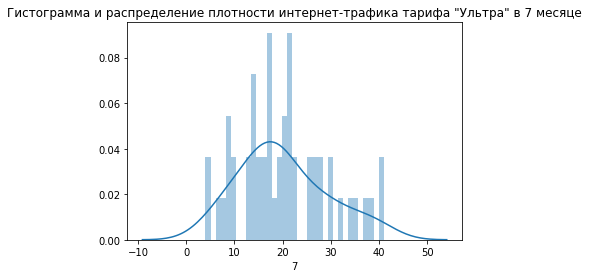

Дисперсия: 84


count    52.000000
mean     20.076923
std       9.141258
min       4.000000
25%      14.000000
50%      19.000000
75%      26.250000
max      41.000000
Name: 7, dtype: float64

____________________________________________________________________________________________________ Месяц: 8 



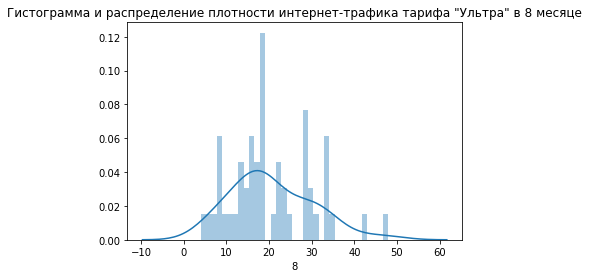

Дисперсия: 90


count    52.000000
mean     20.634615
std       9.503413
min       4.000000
25%      14.750000
50%      19.000000
75%      28.000000
max      48.000000
Name: 8, dtype: float64

____________________________________________________________________________________________________ Месяц: 9 



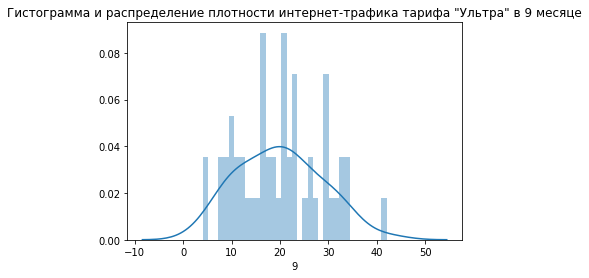

Дисперсия: 74


count    52.000000
mean     19.942308
std       8.614656
min       4.000000
25%      12.750000
50%      20.500000
75%      26.000000
max      42.000000
Name: 9, dtype: float64

____________________________________________________________________________________________________ Месяц: 10 



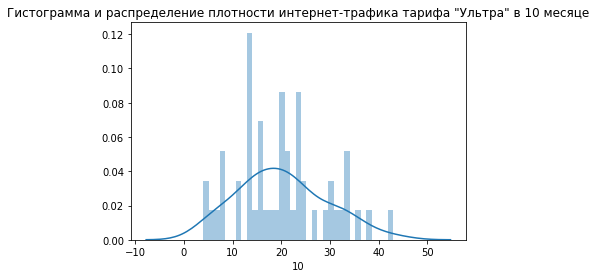

Дисперсия: 82


count    52.000000
mean     20.134615
std       9.040278
min       4.000000
25%      14.000000
50%      20.000000
75%      25.000000
max      43.000000
Name: 10, dtype: float64

____________________________________________________________________________________________________ Месяц: 11 



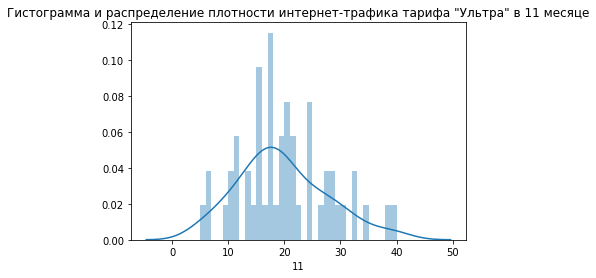

Дисперсия: 63


count    52.000000
mean     19.596154
std       7.958864
min       5.000000
25%      15.000000
50%      19.000000
75%      24.000000
max      40.000000
Name: 11, dtype: float64

____________________________________________________________________________________________________ Месяц: 12 



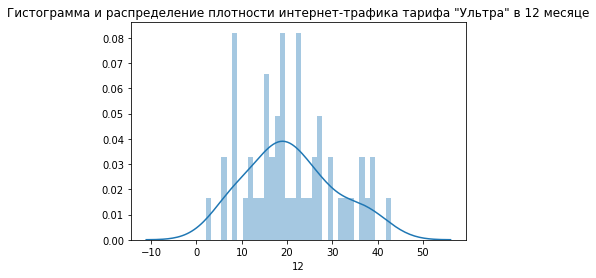

Дисперсия: 95


count    52.000000
mean     20.826923
std       9.743215
min       2.000000
25%      14.750000
50%      19.000000
75%      27.000000
max      43.000000
Name: 12, dtype: float64

In [121]:
internet_ultra_allnot0_std = [] 
internet_ultra_allnot0_mean = []

print('Статистика по интернет-трафику с апреля по декабрь 2018. Тариф: "Ультра"\n')

for column in [str(x) for x in range(4, 13)]:
    
    internet_month = internet_allnot0[internet_allnot0['tariff'] == 'ultra'][column]
    desc = internet_month.describe()
    internet_ultra_allnot0_mean.append(desc[1])
    internet_ultra_allnot0_std.append(desc[2])
    print('_' * 100, 'Месяц:', column, '\n')
        
    sns.distplot(
        internet_month,
        bins = 35,
    )
    
    plt.title(f'Гистограмма и распределение плотности интернет-трафика тарифа "Ультра" в {column} месяце')
    plt.show()
    
    print(f'Дисперсия: {internet_month.var():.0f}')
    display(desc)

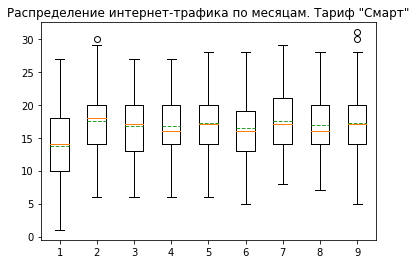

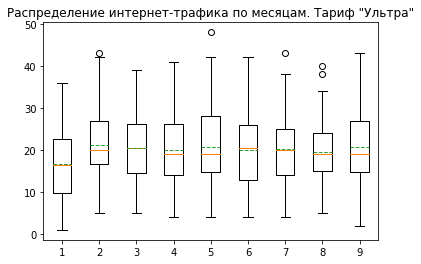

In [122]:
internet_smart_month_boxplot = []

for column in [str(x) for x in range(4, 13)]:
    internet_smart_month_boxplot.append(internet_allnot0[internet_allnot0['tariff'] == 'smart'][column])
    
plt.boxplot(internet_smart_month_boxplot, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)
plt.title('Распределение интернет-трафика по месяцам. Тариф "Смарт"')
plt.show()

internet_ultra_month_boxplot = []

for column in [str(x) for x in range(4, 13)]:
    internet_ultra_month_boxplot.append(internet_allnot0[internet_allnot0['tariff'] == 'ultra'][column])
    
plt.boxplot(internet_ultra_month_boxplot, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)
plt.title('Распределение интернет-трафика по месяцам. Тариф "Ультра"')
plt.show()

Изменение среднего значения интернет-трафика по месяцам

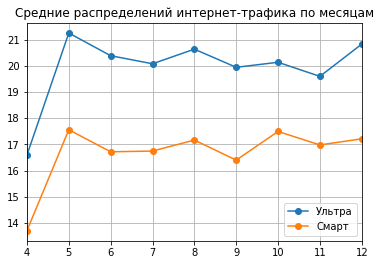

Среднее значение интернет-трафика в Гб
Тариф "Смарт": [17.0]
Тариф "Ультра": [20.0]


In [123]:
df1 = pd.DataFrame(internet_ultra_allnot0_mean)
df1.index = [str(x) for x in range(4, 13)]
ax = df1.plot(style='o-', legend=False, grid=True, rot=1)

df2 = pd.DataFrame(internet_smart_allnot0_mean)
df2.index = [str(x) for x in range(4, 13)]
df2.plot(style='o-', legend=False, grid=True, rot=1, ax=ax)

plt.legend(['Ультра', 'Смарт'])
plt.title('Средние распределений интернет-трафика по месяцам')
plt.show()

print(f'Среднее значение интернет-трафика в Гб')
print(f'Тариф "Смарт": {df2.mean().round().to_list()}')
print(f'Тариф "Ультра": {df1.mean().round().to_list()}')

Изменение стандартного отклонения распределений интернет-трафика по месяцам

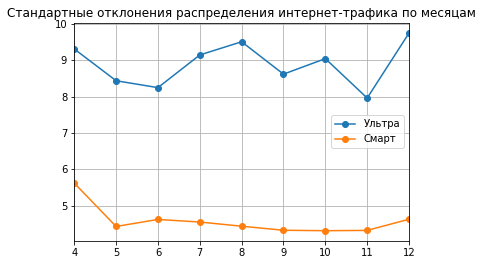

Среднее стандартное отклонение интернет-трафика
Тариф "Смарт": [5.0]
Тариф "Ультра": [9.0]


In [124]:
df1 = pd.DataFrame(internet_ultra_allnot0_std)
df1.index = [str(x) for x in range(4, 13)]
ax = df1.plot(style='o-', legend=False, grid=True, rot=1)

df2 = pd.DataFrame(internet_smart_allnot0_std)
df2.index = [str(x) for x in range(4, 13)]
df2.plot(style='o-', legend=False, grid=True, rot=1, ax=ax)

plt.legend(['Ультра', 'Смарт'])
plt.title('Стандартные отклонения распределения интернет-трафика по месяцам')
plt.show()

print(f'Среднее стандартное отклонение интернет-трафика')
print(f'Тариф "Смарт": {df2.mean().round().to_list()}')
print(f'Тариф "Ультра": {df1.mean().round().to_list()}')

Видим распределение, близкое к нормальному. На тарифе "Смарт" мат. ожидание в 17 Мб (при 15 Мб, входящих в аб. плату). На тарифе "Ультра" (при 30 Мб, входящих в аб. плату) видим мат. ожидание в 20 Мб и второй небольшой пик на уровне 35 Мб, максимум составляет 48 Мб минут. Поэтому больше чем половине абонентов тарифа "Смарт" недостаточно имеющегося трафика, а абоненты тарифа "Ультра" в большинстве укладываются в предоставленный объем.

### Выводы

Посчитали среднее количество, дисперсию и стандартное отклонение. Построили гистограммы. Описали распределения. Описали поведение клиентов оператора, исходя из выборки: сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

## Проверка гипотез

Будем проверять 2 гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Пороговое значение alpha зададим на уровне 1%.

Поясним:
* как формулировали нулевую и альтернативную гипотезы;
* какой критерий использовали для проверки гипотез и почему.

### Гипотеза 1

**Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются**

Нам следует принять за нулевую гипотезу Н0 гипотезу о равенстве выручки пользователей двух тарифов (нулевая гипотиза всегда утвержадет равенство), а альтернативную гипотезу Н1 - гипотезу о неравенстве выручки в генеральной совокупности всех пользователей данного оператора. Критерием по которому будем судить о гипотезе поставим порог в 1% вероятности получить среднюю выручку одного тарифа равной другому.

In [125]:
total_pivot

,user_id,month,duration,messages,internet,income,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,churn_month
0,1000,1,0,0,0,0,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1
1,1000,2,0,0,0,0,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1
2,1000,3,0,0,0,0,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1
3,1000,4,0,0,0,0,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1
4,1000,5,159,22,3,1950,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1499,8,0,0,0,0,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,9,1
5996,1499,9,70,11,2,550,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,9,1
5997,1499,10,449,48,18,1150,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,9,1
5998,1499,11,612,59,18,1513,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,9,1


Получим две выборки выручки пользователей, различные по тарифам

In [126]:
total_smart_income = total_pivot[total_pivot['tariff'] == 'smart']['income']
total_smart_income

12         0
13         0
14         0
15         0
16         0
        ... 
5995       0
5996     550
5997    1150
5998    1513
5999     598
Name: income, Length: 4212, dtype: int64

In [127]:
total_ultra_income = total_pivot[total_pivot['tariff'] == 'ultra']['income']
total_ultra_income

0          0
1          0
2          0
3          0
4       1950
        ... 
5947    1950
5948    2400
5949    1950
5950    3300
5951    1950
Name: income, Length: 1788, dtype: int64

Сравним дисперсии

In [128]:
print(total_smart_income.var(), '\n')
print(total_ultra_income.var())

768958.0742871347 

1138438.2382268657


Дисперсии отличаются в 6 раз, будем это учитывать

In [129]:
print(total_smart_income.describe(), '\n')
print(total_ultra_income.describe())

count    4212.000000
mean      682.787512
std       876.902545
min         0.000000
25%         0.000000
50%       550.000000
75%      1147.250000
max      6770.000000
Name: income, dtype: float64 

count    1788.000000
mean     1141.526846
std      1066.976213
min         0.000000
25%         0.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: income, dtype: float64


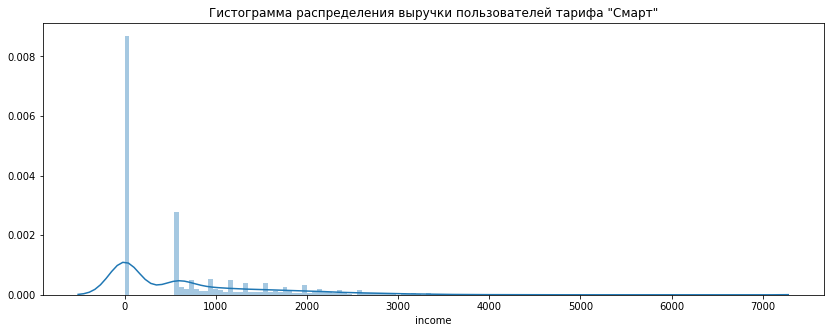

In [130]:
desc = total_smart_income.describe()

f, ax = plt.subplots(figsize=(14,5))
sns.distplot(
        total_smart_income,
        bins = 125,
    )
plt.title('Гистограмма распределения выручки пользователей тарифа "Смарт"')
plt.show()

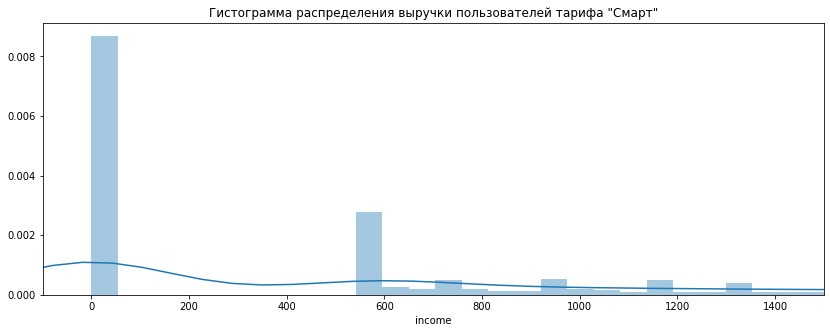

In [131]:
desc = total_smart_income.describe()

f, ax = plt.subplots(figsize=(14,5))
sns.distplot(
        total_smart_income,
        bins = 125,
    )
plt.xlim(-100, 1500)
plt.title('Гистограмма распределения выручки пользователей тарифа "Смарт"')
plt.show()

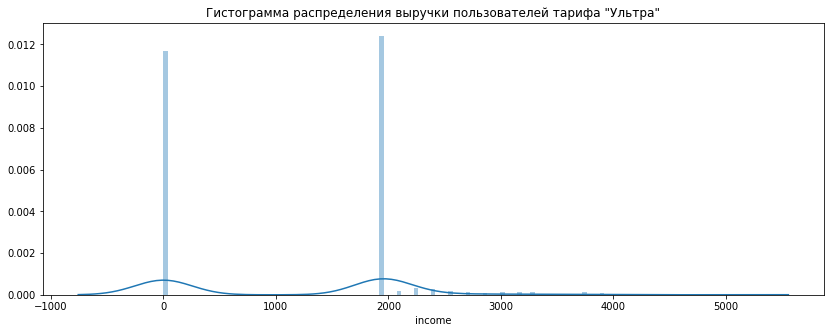

In [132]:
desc = total_ultra_income.describe()

f, ax = plt.subplots(figsize=(14,5))
sns.distplot(
        total_ultra_income,
        bins = 125,
    )
plt.title('Гистограмма распределения выручки пользователей тарифа "Ультра"')
plt.show()

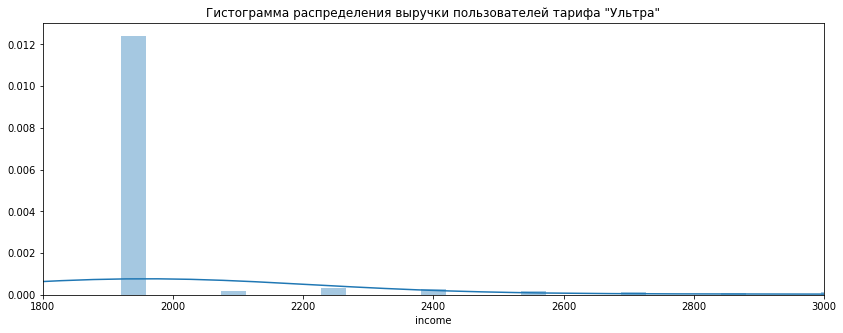

In [133]:
desc = total_ultra_income.describe()

f, ax = plt.subplots(figsize=(14,5))
sns.distplot(
        total_ultra_income,
        bins = 125,
    )
plt.xlim(1800, 3000)
plt.title('Гистограмма распределения выручки пользователей тарифа "Ультра"')
plt.show()

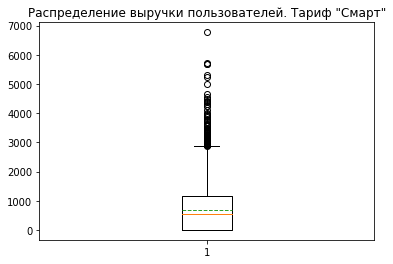

In [134]:
plt.boxplot(total_smart_income, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)
plt.title('Распределение выручки пользователей. Тариф "Смарт"')
plt.show()

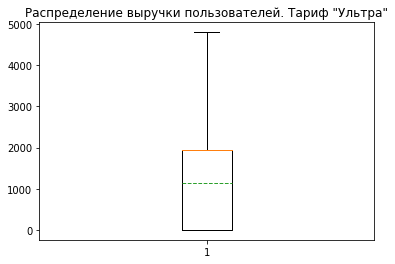

In [135]:
plt.boxplot(total_ultra_income, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)
plt.title('Распределение выручки пользователей. Тариф "Ультра"')
plt.show()

Проведем t-test. Воспользуемся методом нахождения t-критерия Стьюдента о равенстве средних двух совокупностей по их репрезентативным выборкам

In [136]:
alpha = .01 # Примем уровень значимости равным 1%   

# Применим метод ttest_ind() для двух независимых совокупностей, параметр равности дисперсий ставим на False

results = st.ttest_ind(total_smart_income, total_ultra_income, equal_var=False)  

print('p-значение', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Недостаточно оснований отвергнуть нулевую гипотезу')

p-значение 2.003739070365922e-55
Отвергаем нулевую гипотезу


### Гипотеза 2

**Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

Нам следует принять за нулевую гипотезу Н0 гипотезу о равенстве выручки пользователей Москвы и регионов (нулевая гипотиза всегда утверждает равенство), а альтернативную гипотезу Н1 - гипотезу о неравенстве. Критерием, по которому будем судить о гипотезе, поставим порог в 1% вероятности получить среднюю выручку абонентов Москвы равной другим регионам.

Получим две выборки выручки пользователей Москвы и регионов

In [137]:
total_mos_income = total_pivot[total_pivot['city'] == 'Москва']['income']
total_mos_income

12         0
13         0
14         0
15         0
16         0
        ... 
5887     950
5888     550
5889    1750
5890    1350
5891     750
Name: income, Length: 1188, dtype: int64

In [138]:
total_reg_income = total_pivot[total_pivot['city'] != 'Москва']['income']
total_reg_income

0          0
1          0
2          0
3          0
4       1950
        ... 
5995       0
5996     550
5997    1150
5998    1513
5999     598
Name: income, Length: 4812, dtype: int64

Сравним дисперсии

In [139]:
print(total_mos_income.var(), '\n')
print(total_reg_income.var())

888775.2138827194 

931362.192111136


Дисперсии практически не отличаются

In [140]:
print(total_mos_income.describe(), '\n')
print(total_reg_income.describe())

count    1188.000000
mean      795.489899
std       942.748754
min         0.000000
25%         0.000000
50%       550.000000
75%      1825.000000
max      5321.000000
Name: income, dtype: float64 

count    4812.000000
mean      825.417498
std       965.071081
min         0.000000
25%         0.000000
50%       550.000000
75%      1799.500000
max      6770.000000
Name: income, dtype: float64


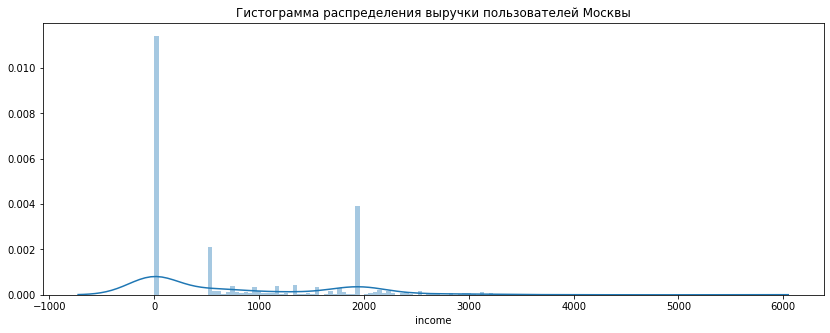

In [141]:
desc = total_mos_income.describe()

f, ax = plt.subplots(figsize=(14,5))
sns.distplot(
        total_mos_income,
        bins = 125,
    )
plt.title('Гистограмма распределения выручки пользователей Москвы')
plt.show()

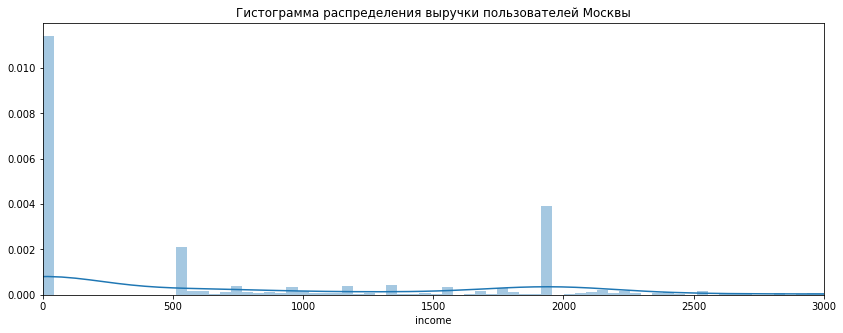

In [142]:
desc = total_mos_income.describe()

f, ax = plt.subplots(figsize=(14,5))
sns.distplot(
        total_mos_income,
        bins = 125,
    )
plt.xlim(0, 3000)
plt.title('Гистограмма распределения выручки пользователей Москвы')
plt.show()

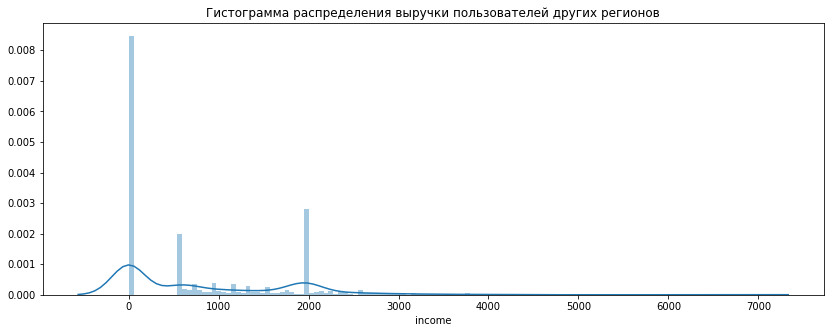

In [143]:
desc = total_reg_income.describe()

f, ax = plt.subplots(figsize=(14,5))
sns.distplot(
        total_reg_income,
        bins = 125,
    )
plt.title('Гистограмма распределения выручки пользователей других регионов')
plt.show()

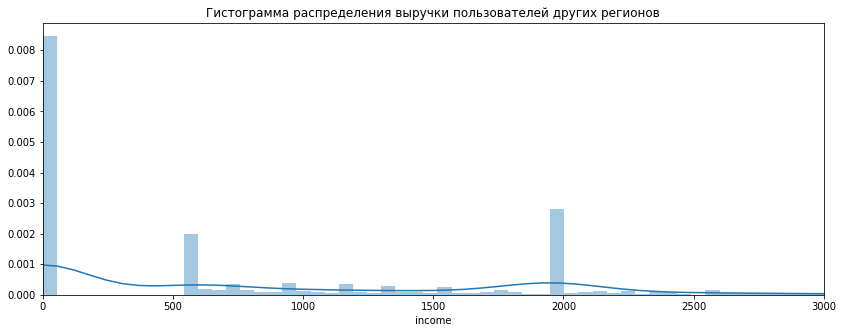

In [144]:
desc = total_reg_income.describe()

f, ax = plt.subplots(figsize=(14,5))
sns.distplot(
        total_reg_income,
        bins = 125,
    )
plt.xlim(0, 3000)
plt.title('Гистограмма распределения выручки пользователей других регионов')
plt.show()

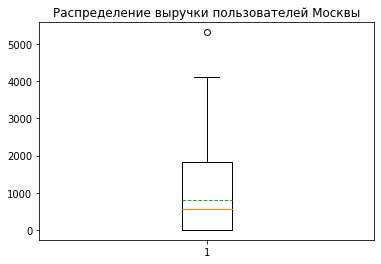

In [145]:
plt.boxplot(total_mos_income, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)
plt.title('Распределение выручки пользователей Москвы')
plt.show()

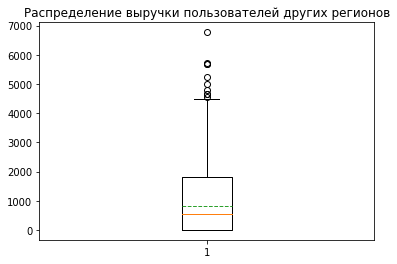

In [146]:
plt.boxplot(total_reg_income, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)
plt.title('Распределение выручки пользователей других регионов')
plt.show()

Проведем t-test. Воспользуемся методом нахождения t-критерия Стьюдента о равенстве средних двух совокупностей по их репрезентативным выборкам

In [147]:
alpha = .01 # Примем уровень значимости равным 1%  

# Применим метод ttest_ind() для двух независимых совокупностей

results = st.ttest_ind(total_mos_income, total_reg_income)  

print('p-значение', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Недостаточно оснований отвергнуть нулевую гипотезу')

p-значение 0.3363033067088109
Недостаточно оснований отвергнуть нулевую гипотезу


Теперь проведем t-test для соответствующих групп согласно тарифу

Получим 4 выборки для разных тарифов и регионов

In [148]:
total_mos_smart_income = total_pivot[(total_pivot['city'] == 'Москва') & (total_pivot['tariff'] == 'smart')]['income']
total_mos_smart_income

12         0
13         0
14         0
15         0
16         0
        ... 
5887     950
5888     550
5889    1750
5890    1350
5891     750
Name: income, Length: 804, dtype: int64

In [149]:
total_mos_ultra_income = total_pivot[(total_pivot['city'] == 'Москва') & (total_pivot['tariff'] == 'ultra')]['income']
total_mos_ultra_income

36         0
37         0
38         0
39         0
40         0
        ... 
5719    1950
5720    1950
5721    1950
5722    1950
5723    1950
Name: income, Length: 384, dtype: int64

In [150]:
total_reg_smart_income = total_pivot[(total_pivot['city'] != 'Москва') & (total_pivot['tariff'] == 'smart')]['income']
total_reg_smart_income

24         0
25         0
26         0
27         0
28         0
        ... 
5995       0
5996     550
5997    1150
5998    1513
5999     598
Name: income, Length: 3408, dtype: int64

In [151]:
total_reg_ultra_income = total_pivot[(total_pivot['city'] != 'Москва') & (total_pivot['tariff'] == 'ultra')]['income']
total_reg_ultra_income

0          0
1          0
2          0
3          0
4       1950
        ... 
5947    1950
5948    2400
5949    1950
5950    3300
5951    1950
Name: income, Length: 1404, dtype: int64

t-test для тарифа "Смарт"

In [152]:
alpha = .01 # Примем уровень значимости равным 1%  

# Применим метод ttest_ind() для двух независимых совокупностей

results = st.ttest_ind(total_mos_smart_income, total_reg_smart_income)  

print('p-значение', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Недостаточно оснований отвергнуть нулевую гипотезу')

p-значение 0.0015965990652218986
Отвергаем нулевую гипотезу


t-test для тарифа "Ультра"

In [153]:
alpha = .01 # Примем уровень значимости равным 1%  

# Применим метод ttest_ind() для двух независимых совокупностей

results = st.ttest_ind(total_mos_ultra_income, total_reg_ultra_income)  

print('p-значение', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Недостаточно оснований отвергнуть нулевую гипотезу')

p-значение 0.12663563758631363
Недостаточно оснований отвергнуть нулевую гипотезу


### Выводы

По выдвинутым гипотезам были получены следующие результаты с уровнем статистической значимости 1% (также верно и для 5%): 

**Альтернативная гипотеза о различии средней выручки пользователей тарифов «Ультра» и «Смарт» была принята, т.к. нулевая гипотеза об их равенстве была отвергнута.**

**Альтернативная гипотеза о различии средней выручки пользователей двух тарифов Москвы и других регионов не была принята, т.к. недостаточно оснований отвергнуть нулевую гипотезу об их равенстве.**

**Альтернативная гипотеза о различии средней выручки пользователей тарифа "Ультра" Москвы и других регионов не была принята, т.к. недостаточно оснований отвергнуть нулевую гипотезу об их равенстве.**

**Альтернативная гипотеза о различии средней выручки пользователей тарифа "Смарт" Москвы и других регионов была принята, т.к. нулевая гипотеза об их равенстве была отвергнута.**

Вследствие того, что выборки были распрелены нормально, а дисперсия конечна, применен t-test - метод нахождения t-критерия Стьюдента о равенстве средних двух совокупностей по их репрезентативным выборкам. 

## Общие выводы

* Были описаны выявленные в данных проблемы, данные поготовлены  к анализу
* Построены гистограммы распределений случайных величин и их вероятностей
* Проинтерпретированы полученные графики
* Рассчитаны стандартное отклонение и дисперсия
* Сформулированы альтернативные и нулевые гипотезы, 2-я гипотеза была поделена на три
* Для проверки гипотез применен t-test - метод нахождения t-критерия Стьюдента о равенстве средних двух совокупностей по их репрезентативным выборкам.
* Результат проверки гипотезы был адекватно интерпретирован 
* Структура проекта соблюдалась, аккуратность кода поддерживалась
* Выводы сформулированы после каждого раздела
* Оставлены комментарии практически ко всем шагам